In [1]:
!pip install geopandas

In [2]:
!pip install datashader

In [3]:
!pip install dataframe_image selenium

In [4]:
!pip install gcsfs

In [5]:
import operator
import pathlib

import numpy as np
import pandas as pd
import geopandas
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import colorcet
import datashader as ds
from datashader.utils import export_image

In [6]:
import dataframe_image as dfi

In [7]:
gcp_project = 'foresight-375620'
gcp_bucket = 'frsght'

#import google.auth
#from google.colab import auth

# authenticate with gcp
#auth.authenticate_user()
#credentials, project_id = google.auth.default()

In [8]:
!gcloud config set project $gcp_project
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse=0.41.12

# create colab instance directory
!mkdir -p $gcp_bucket
# mount gcp bucket to colab instance directory.
# at /content/gcp_bucket
!gcsfuse  --implicit-dirs --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $gcp_bucket $gcp_bucket
!gcsfuse  --implicit-dirs  --stat-cache-ttl 12h --type-cache-ttl 12h --stat-cache-capacity 65536 --limit-bytes-per-sec -1 --limit-ops-per-sec -1 $gcp_bucket $gcp_bucket

Updated property [core/project].
zsh:1: no such file or directory: /etc/apt/sources.list.d/gcsfuse.list
zsh:1: command not found: apt-key
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1210  100  1210    0     0   4299      0 --:--:-- --:--:-- --:--:--  4352
curl: (23) Failed writing body
The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

The operation couldn’t be completed. Unable to locate a Java Runtime.
Please visit http://www.java.com for information on installing Java.

zsh:1: command not found: gcsfuse
zsh:1: command not found: gcsfuse


In [16]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

In [17]:
# create dict mapping fips to iso3 country codes
ccodes = pd.read_csv("gcs://frsght/datasets/country_codes.csv")
fips_iso3_map = dict(zip(ccodes['fips (geonames)'].values, ccodes['ISO3 (geonames)'].values))

In [18]:
meta = {'transformer': {'path': 'gcs://frsght/model_predictions/chad_preds.csv',
                        'fips': 'Code', 'y_pred': 'class_preds',
                        'y_pred_proba': 'preds', 'y_true': 'Spike'},
        'xgboost': {'path': 'gcs://frsght/model_predictions/diana_preds.csv',
                    'fips': 'fips', 'y_pred': 'prediction',
                    'y_pred_proba': 'probabilities', 'y_true': 'lagged_spike'},
        'ffnn': {'path': 'gcs://frsght/model_predictions/evan_preds_updated.csv',
                 'fips': 'fips', 'y_pred': 'preds',
                 'y_pred_proba': 'preds_proba', 'y_true': 'Spike_3'},
        'ensemble': {'fips': 'fips', 'y_pred': 'y_pred',
                     'y_pred_proba': 'y_pred_proba', 'y_true': 'y_true'}}

In [19]:
pred_threshold = 0.5

In [20]:
dft = pd.read_csv("gcs://frsght/model_predictions/chad_preds.csv").drop_duplicates()
dft['model'] = 'transformer'
dft['class_preds'] = dft['preds'] > pred_threshold

dfx = pd.read_csv("gcs://frsght/model_predictions/diana_preds.csv").drop_duplicates()
dfx['yearmonth'] = pd.to_datetime(dfx['embedding_window']).dt.strftime("%Y%m")
dfx['model'] = 'xgboost'
dfx['prediction'] = dfx['probabilities'] > pred_threshold

dfn = pd.read_csv("gcs://frsght/model_predictions/evan_preds_updated.csv").drop_duplicates()
dfn['yearmonth'] = dfn['embedding_window']
dfn['model'] = 'ffnn'
dfn = dfn.drop(columns=['Unnamed: 0'])
dfn['preds'] = dfn['preds_proba'] > pred_threshold

In [21]:
dfs = {'transformer': dft, 'xgboost': dfx, 'ffnn': dfn}#, 'ensemble': dfe}

>>>  transformer (615, 20)
[[371 158]
 [ 46  40]] 

              precision    recall  f1-score   support

       False       0.89      0.70      0.78       529
        True       0.20      0.47      0.28        86

    accuracy                           0.67       615
   macro avg       0.55      0.58      0.53       615
weighted avg       0.79      0.67      0.71       615
 




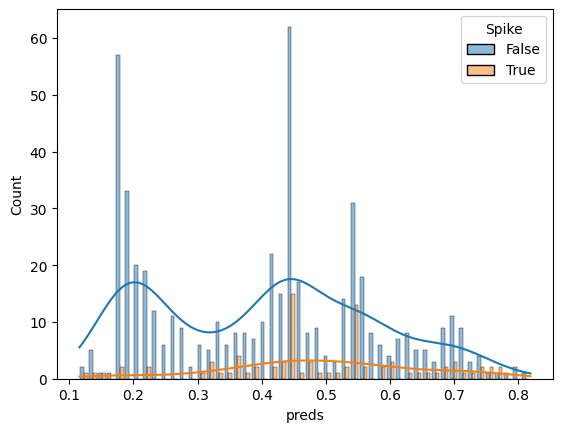

>>>  xgboost (406, 16)
[[172 181]
 [ 15  38]] 

              precision    recall  f1-score   support

       False       0.92      0.49      0.64       353
        True       0.17      0.72      0.28        53

    accuracy                           0.52       406
   macro avg       0.55      0.60      0.46       406
weighted avg       0.82      0.52      0.59       406
 




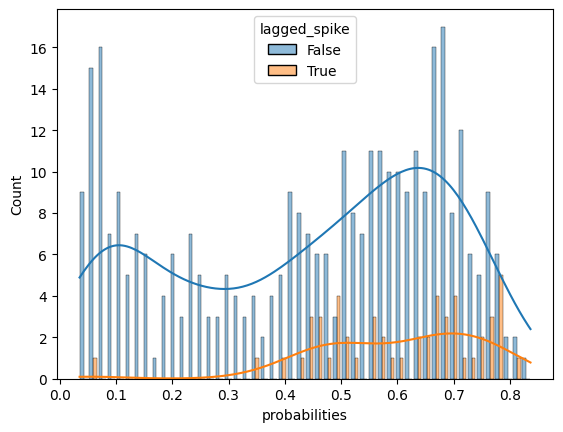

>>>  ffnn (673, 14)
[[463 109]
 [ 60  41]] 

              precision    recall  f1-score   support

       False       0.89      0.81      0.85       572
        True       0.27      0.41      0.33       101

    accuracy                           0.75       673
   macro avg       0.58      0.61      0.59       673
weighted avg       0.79      0.75      0.77       673
 




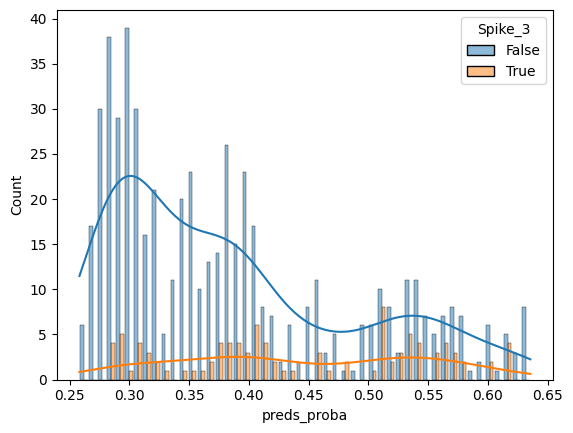

In [22]:
for m, df in dfs.items():
    df['iso3'] = df[meta[m]['fips']].map(fips_iso3_map)
    df = world.merge(df, right_on='iso3', left_on='iso_a3')
    df['yearmonth'] = df['yearmonth'].astype(str)
    bools = ['y_pred', 'y_true']
    for b in bools:
        df[meta[m][b]] = df[meta[m][b]].astype(bool)

    print('>>> ', m, df.shape)
    print(metrics.confusion_matrix(df[meta[m]['y_true']], df[meta[m]['y_pred']]), '\n')
    print(metrics.classification_report(df[meta[m]['y_true']], df[meta[m]['y_pred']]), '\n\n')
    sns.histplot(data=df, x=meta[m]['y_pred_proba'], hue=meta[m]['y_true'], bins=50, kde=True, multiple="dodge", shrink=.8)
    plt.show()
    dfs.update({m: df})

In [23]:
dft = dfs['transformer']
dfx = dfs['xgboost']
dfn = dfs['ffnn']

In [24]:
# create alternate df versions with same columns
_dft = dft.copy().rename(columns={'Code': 'fips', 'class_preds': 'y_pred',
                           'preds': 'y_pred_proba', 'Spike': 'y_true'})
_dft = _dft[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']]

_dfx = dfx.copy().rename(columns={'prediction': 'y_pred',
                           'probabilities': 'y_pred_proba', 'lagged_spike': 'y_true'})
_dfx = _dfx[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']]

_dfn = dfn.copy().rename(columns={'preds': 'y_pred',
                           'preds_proba': 'y_pred_proba', 'Spike_3': 'y_true'})
_dfn = _dfn[['fips', 'y_pred', 'y_pred_proba', 'y_true',
             'yearmonth', 'model']]

In [25]:
def mutate_alt(df):
    print(df.shape)
    df['iso3'] = df['fips'].map(fips_iso3_map)
    df['yearmonth'] = df['yearmonth'].astype(str)
    df['y_true'] = df['y_true'].astype(bool)
    df = df.set_index(['yearmonth', 'fips'])
    print(df.shape)
    return df

In [26]:
_dft = mutate_alt(_dft)
_dfx = mutate_alt(_dfx)
_dfn = mutate_alt(_dfn)

(615, 6)
(615, 5)
(406, 6)
(406, 5)
(673, 6)
(673, 5)


In [27]:
_dfs = dict(zip(['transformer', 'xgboost', 'ffnn'], [_dft, _dfx, _dfn]))

In [28]:
# join all model predictions
_dfa = _dft.merge(_dfx, left_index=True, right_index=True, suffixes=('_t', '_x'), how="inner")
_dfa = _dfa.merge(_dfn, left_index=True, right_index=True, suffixes=('_a', '_n'), how="inner")

# make an 'ensemble' with mean prediction probabilities
dfe = pd.DataFrame({'y_pred_proba': _dfa[['y_pred_proba_t','y_pred_proba_x', 'y_pred_proba']].mean(axis=1),
                    'y_true': _dfa['y_true_t']})
dfe['y_pred'] = dfe['y_pred_proba'].round().astype(bool)

In [29]:
_dfa.shape

(364, 15)

In [30]:
# each set of predictions has different yearmonths, so many nulls
_dfa = _dfa.dropna(subset=['y_true', 'y_true_t', 'y_true_x'])

In [31]:
common_yearmonths = set.intersection(*[set(df.reset_index()['yearmonth'].unique()) for df in _dfs.values()])
print(common_yearmonths)

{'202211', '202212', '202301'}


In [32]:
_dfa.shape

(364, 15)

In [33]:
_dfa.columns.values

array(['y_pred_t', 'y_pred_proba_t', 'y_true_t', 'model_t', 'iso3_t',
       'y_pred_x', 'y_pred_proba_x', 'y_true_x', 'model_x', 'iso3_x',
       'y_pred', 'y_pred_proba', 'y_true', 'model', 'iso3'], dtype=object)

In [34]:
df_articles = pd.read_csv('datasets_stacked_metadata.csv')
df_articles['yearmonth'] = df_articles['yearmonth'].astype('string')
df_articles = df_articles.rename(columns={'count': 'article_count'})
df_articles = df_articles.drop(columns='filename')

In [35]:
#_dfa.merge(df_articles, left_on=['yearmonth', 'fips'], right_on=['yearmonth', 'country'])

In [36]:
# true values of targets agree for only half of country-yearmonths
#https://stackoverflow.com/questions/22701799/pandas-dataframe-find-rows-where-all-columns-equal#comment99200717_22701944
sum(_dfa[['y_true', 'y_true_t', 'y_true_x']].eq(_dfa[['y_true', 'y_true_t', 'y_true_x']].iloc[:, 0], axis=0).all(axis=1))

269

In [37]:
_dfa[['y_true', 'y_true_t', 'y_true_x']].apply(set, axis=1).apply(len).mean()

1.260989010989011

In [38]:
_dfa[_dfa['y_true'].ne(_dfa['y_true_t'])][['y_true', 'y_true_t', 'y_true_x']]

Empty DataFrame
Columns: [y_true, y_true_t, y_true_x]
Index: []

In [39]:
_dfa[_dfa['y_true_x'].ne(_dfa['y_true_t'])][['y_true', 'y_true_t', 'y_true_x']]

y_true  y_true_t  y_true_x
yearmonth fips                            
202211    TZ     False     False      True
202212    TZ     False     False      True
202301    TZ      True      True     False
202212    US     False     False      True
          ID     False     False      True
...                ...       ...       ...
202211    RW     False     False      True
202212    RW      True      True     False
202301    RW      True      True     False
202211    TD     False     False      True
202301    TD      True      True     False

[95 rows x 3 columns]

In [40]:
_dfa[_dfa['y_true'].ne(_dfa['y_true_x'])][['y_true', 'y_true_t', 'y_true_x']]

y_true  y_true_t  y_true_x
yearmonth fips                            
202211    TZ     False     False      True
202212    TZ     False     False      True
202301    TZ      True      True     False
202212    US     False     False      True
          ID     False     False      True
...                ...       ...       ...
202211    RW     False     False      True
202212    RW      True      True     False
202301    RW      True      True     False
202211    TD     False     False      True
202301    TD      True      True     False

[95 rows x 3 columns]

In [41]:
preds_by_country = list()
for m, true_col, pred_col in [('ffnn', 'y_true', 'y_pred'),
                              ('transformer', 'y_true_t', 'y_pred_t'),
                              ('xgboost', 'y_true_x', 'y_pred_x')]:
    correct_by_country = (_dfa.groupby('fips')
                          .apply(lambda x: x[true_col].eq(x[pred_col]).sum()))
    incorrect_by_country = (_dfa.groupby('fips')
                            .apply(lambda x: x[true_col].ne(x[pred_col]).sum()))
    
    _dfa_true = _dfa[_dfa[true_col].astype(bool)==True]
    true_correct_by_country = (_dfa_true.groupby('fips')
                            .apply(lambda x: x[true_col].eq(x[pred_col]).sum()))
    true_incorrect_by_country = (_dfa_true.groupby('fips')
                            .apply(lambda x: x[true_col].ne(x[pred_col]).sum()))
    
    _dfa_false = _dfa[_dfa[true_col].astype(bool)==False]
    false_correct_by_country = (_dfa_false.groupby('fips')
                          .apply(lambda x: x[true_col].eq(x[pred_col]).sum()))
    false_incorrect_by_country = (_dfa_false.groupby('fips')
                            .apply(lambda x: x[true_col].ne(x[pred_col]).sum()))
    
    preds_by_country.append(pd.DataFrame({'correct': correct_by_country,
                                          'incorrect': incorrect_by_country,
                                          'correct_true': true_correct_by_country,
                                          'incorrect_true': true_incorrect_by_country,
                                          'correct_false': false_correct_by_country,
                                          'incorrect_false': false_incorrect_by_country,
                                          'model': m}))
df_pc = pd.concat(preds_by_country)
df_pc = df_pc.reset_index()
df_pc['iso3'] = df_pc['fips'].map(fips_iso3_map)
df_pc = world.merge(df_pc, right_on='iso3', left_on='iso_a3')

In [42]:
df_pc

pop_est      continent                 name iso_a3  gdp_md_est  \
0      889953.0        Oceania                 Fiji    FJI        5496   
1      889953.0        Oceania                 Fiji    FJI        5496   
2      889953.0        Oceania                 Fiji    FJI        5496   
3    58005463.0         Africa             Tanzania    TZA       63177   
4    58005463.0         Africa             Tanzania    TZA       63177   
..          ...            ...                  ...    ...         ...   
409    622137.0         Europe           Montenegro    MNE        5542   
410    622137.0         Europe           Montenegro    MNE        5542   
411   1394973.0  North America  Trinidad and Tobago    TTO       24269   
412   1394973.0  North America  Trinidad and Tobago    TTO       24269   
413   1394973.0  North America  Trinidad and Tobago    TTO       24269   

                                              geometry fips  correct  \
0    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   FJ        2   
1    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   FJ        2   
2    MULTIPOLYGON (((180.00000 -16.06713, 180.00000...   FJ        2   
3    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   TZ        1   
4    POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...   TZ        3   
..                                                 ...  ...      ...   
409  POLYGON ((20.07070 42.58863, 19.80161 42.50009...   MJ        2   
410  POLYGON ((20.07070 42.58863, 19.80161 42.50009...   MJ        2   
411  POLYGON ((-61.68000 10.76000, -61.10500 10.890...   TD        2   
412  POLYGON ((-61.68000 10.76000, -61.10500 10.890...   TD        1   
413  POLYGON ((-61.68000 10.76000, -61.10500 10.890...   TD        1   

     incorrect  correct_true  incorrect_true  correct_false  incorrect_false  \
0            0           NaN             NaN            2.0              0.0   
1            0           NaN             NaN            2.0              0.0   
2            0           NaN             NaN            2.0              0.0   
3            2           1.0             0.0            0.0              2.0   
4            0           1.0             0.0            2.0              0.0   
..         ...           ...             ...            ...              ...   
409          0           NaN             NaN            2.0              0.0   
410          0           NaN             NaN            2.0              0.0   
411          1           0.0             1.0            2.0              0.0   
412          2           1.0             0.0            0.0              2.0   
413          2           1.0             0.0            0.0              2.0   

           model iso3  
0           ffnn  FJI  
1    transformer  FJI  
2        xgboost  FJI  
3           ffnn  TZA  
4    transformer  TZA  
..           ...  ...  
409  transformer  MNE  
410      xgboost  MNE  
411         ffnn  TTO  
412  transformer  TTO  
413      xgboost  TTO  

[414 rows x 15 columns]

/opt/homebrew/Caskroom/miniforge/base/envs/magasin/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 3 classes. Setting k to 2.
  warnings.warn(


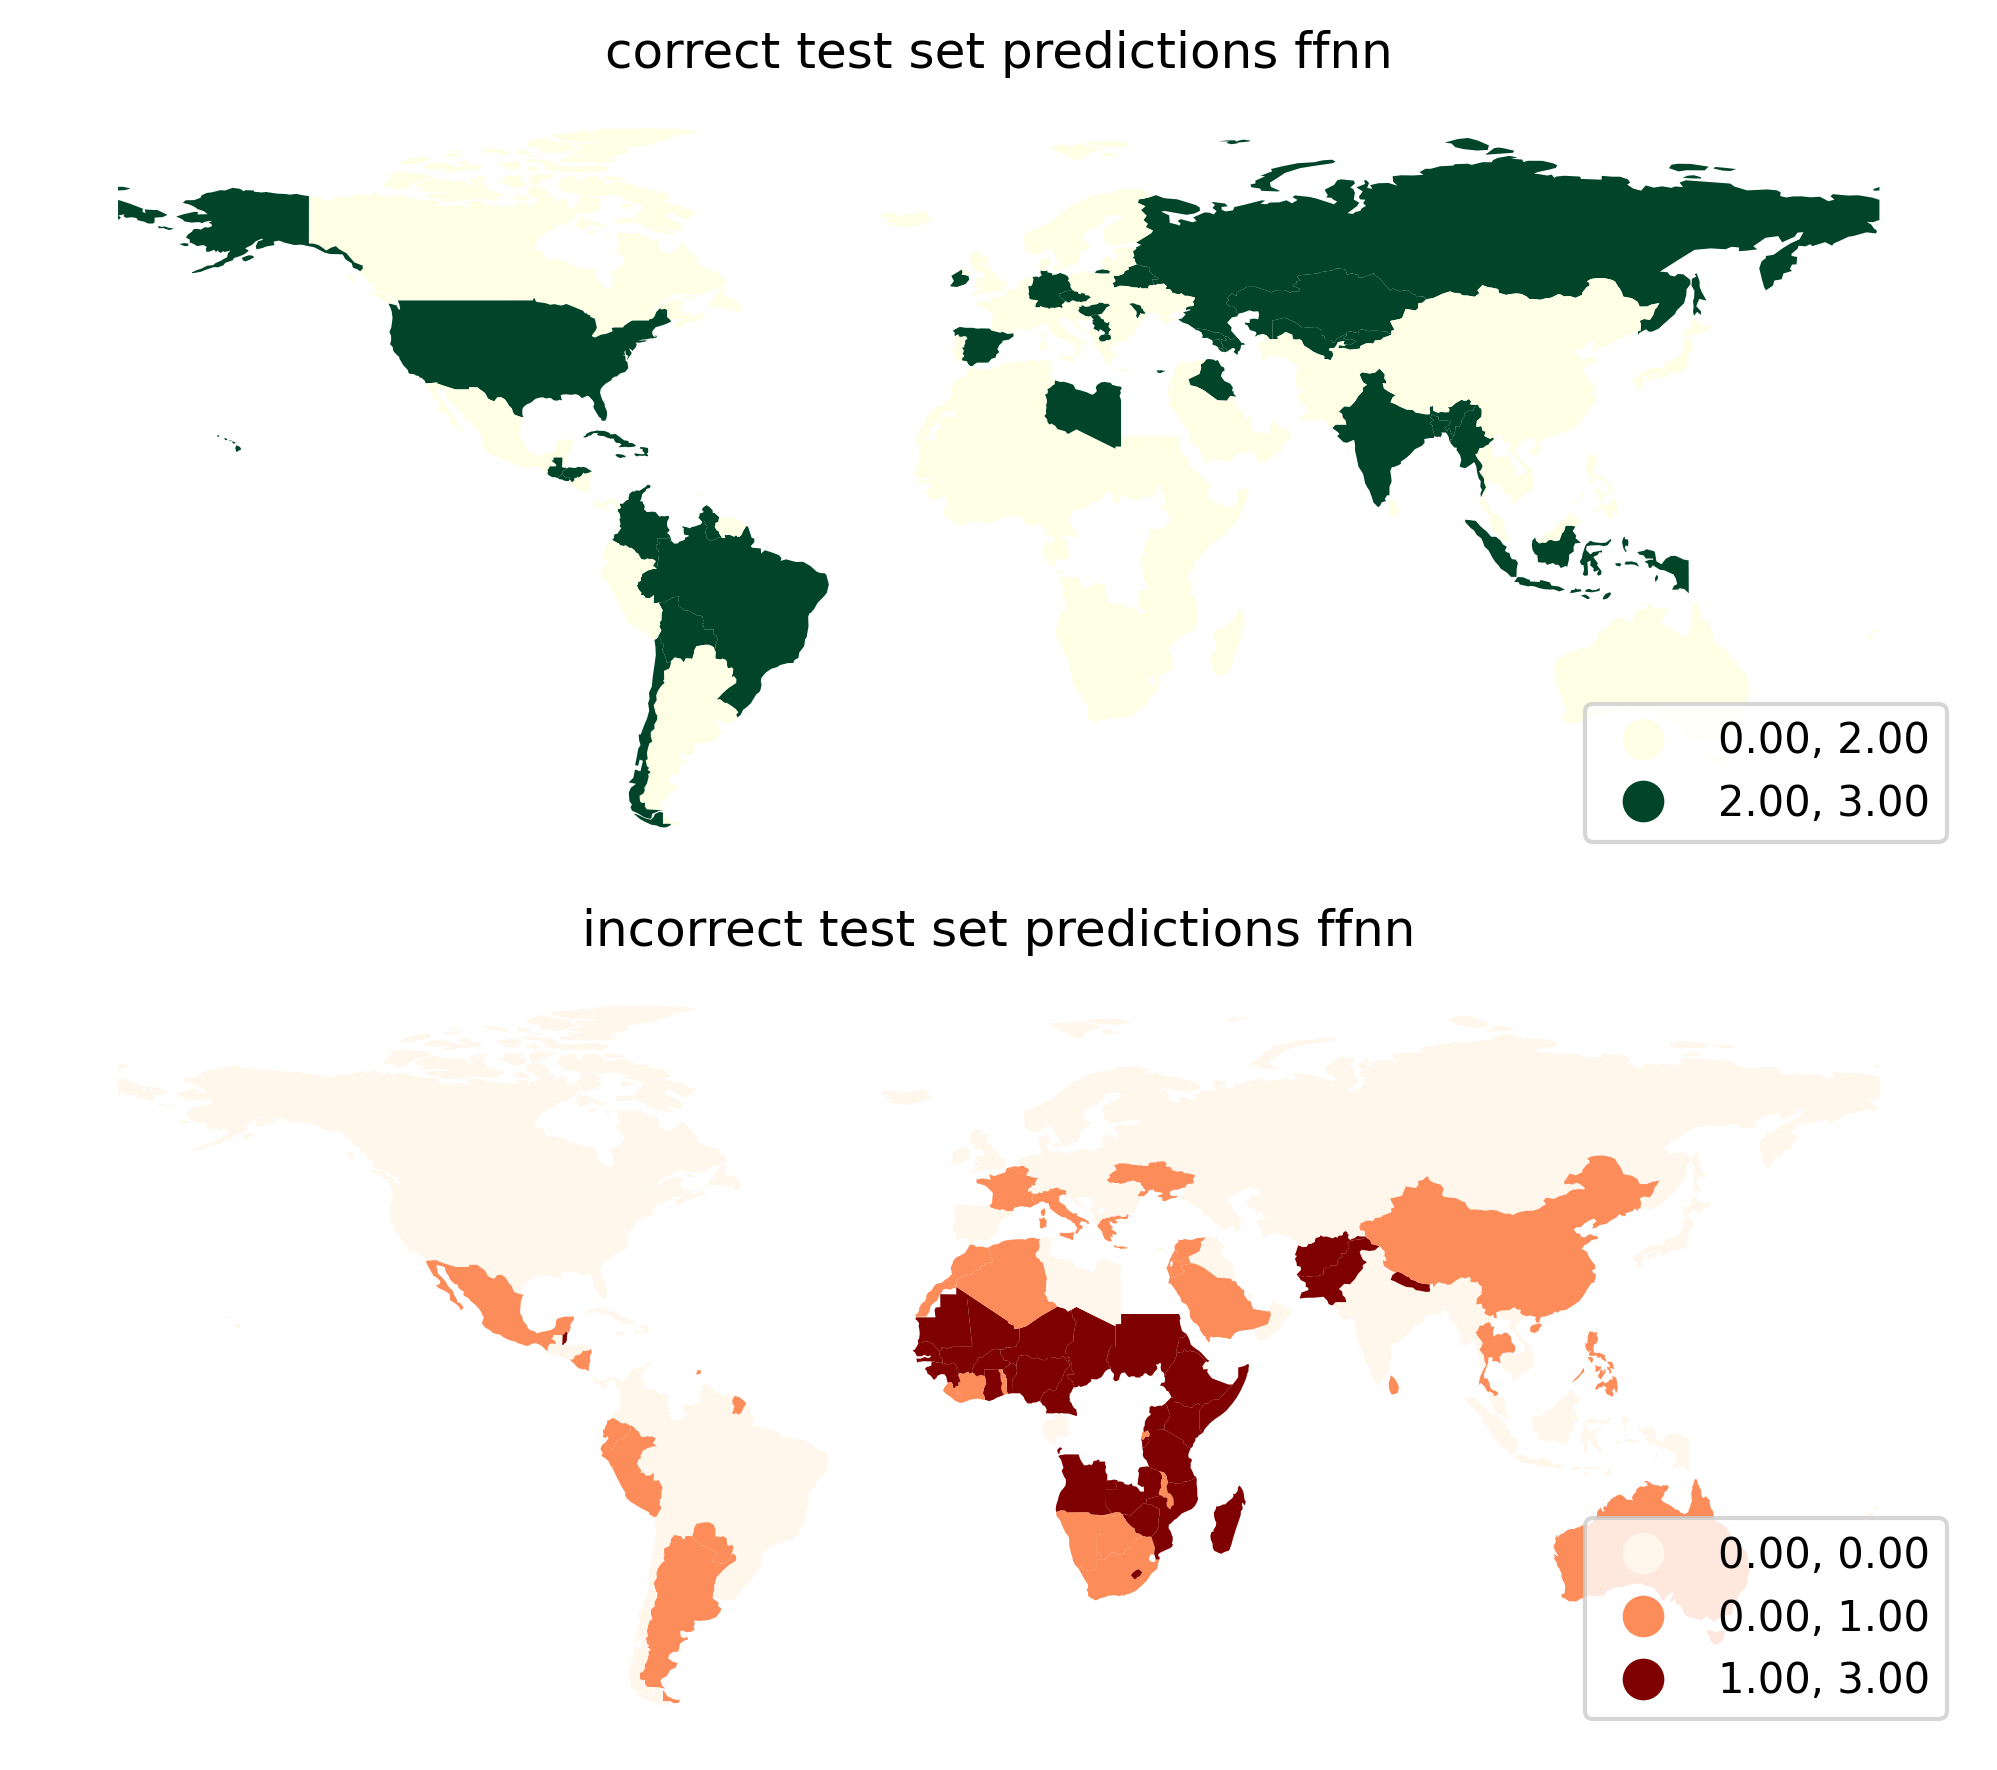

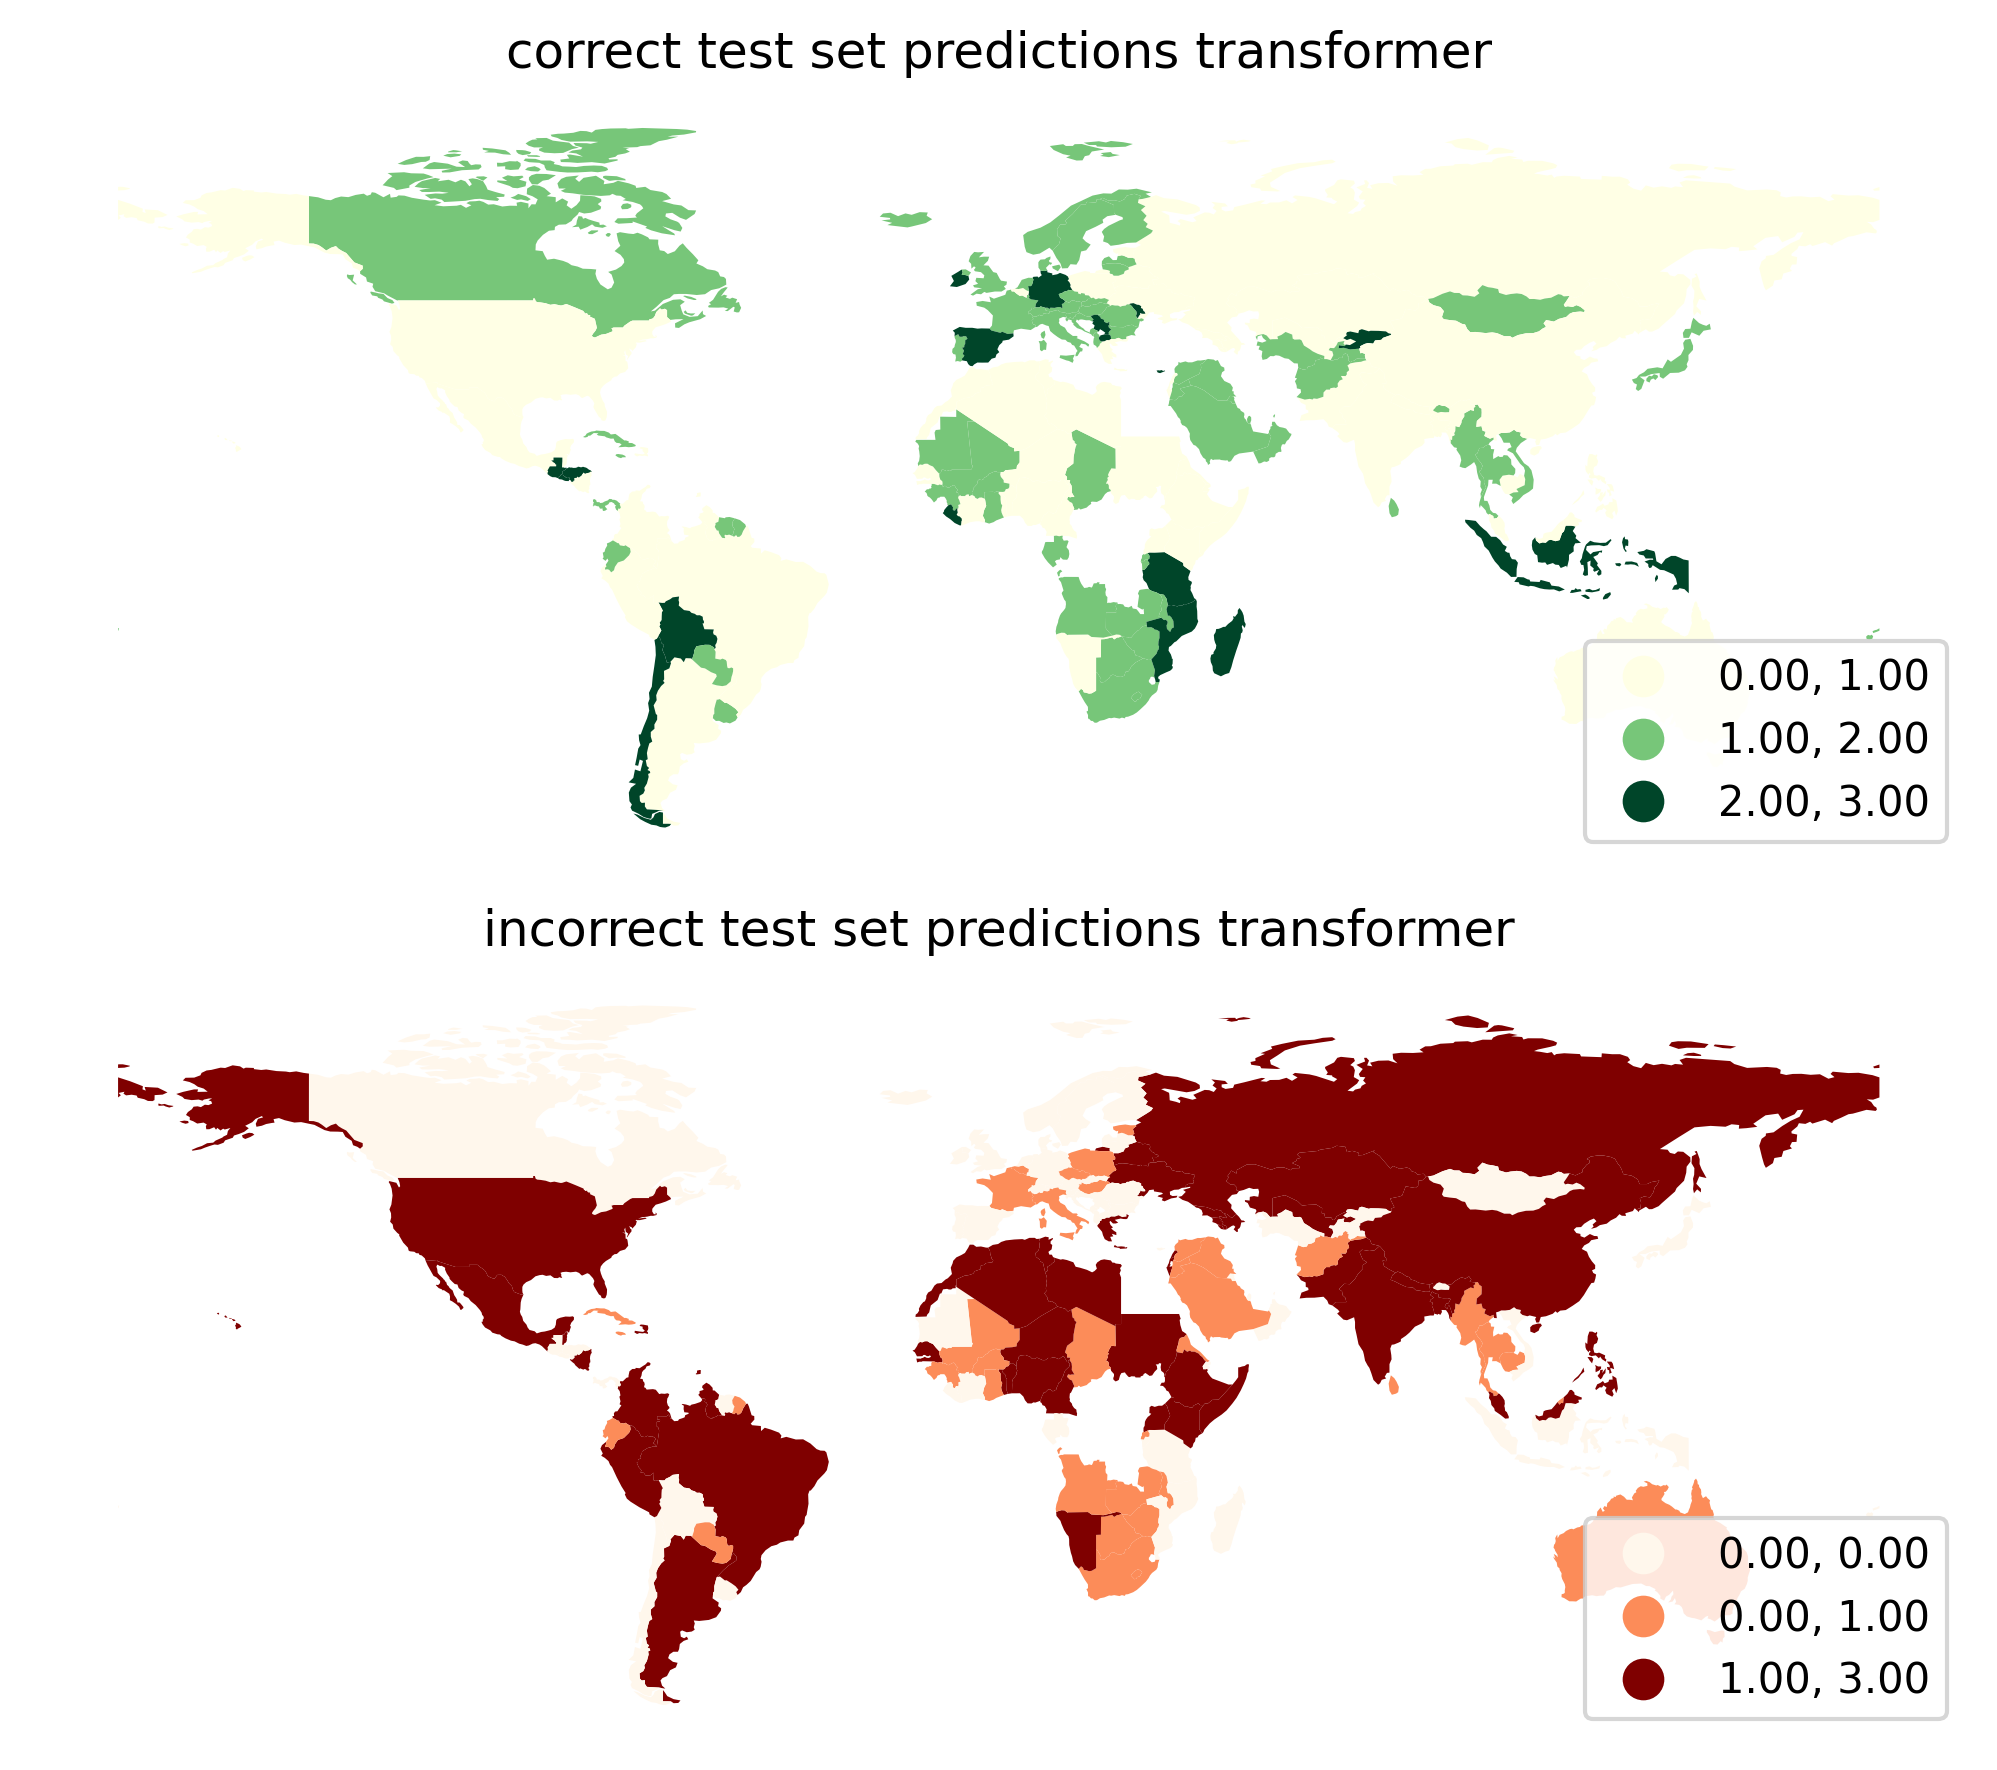

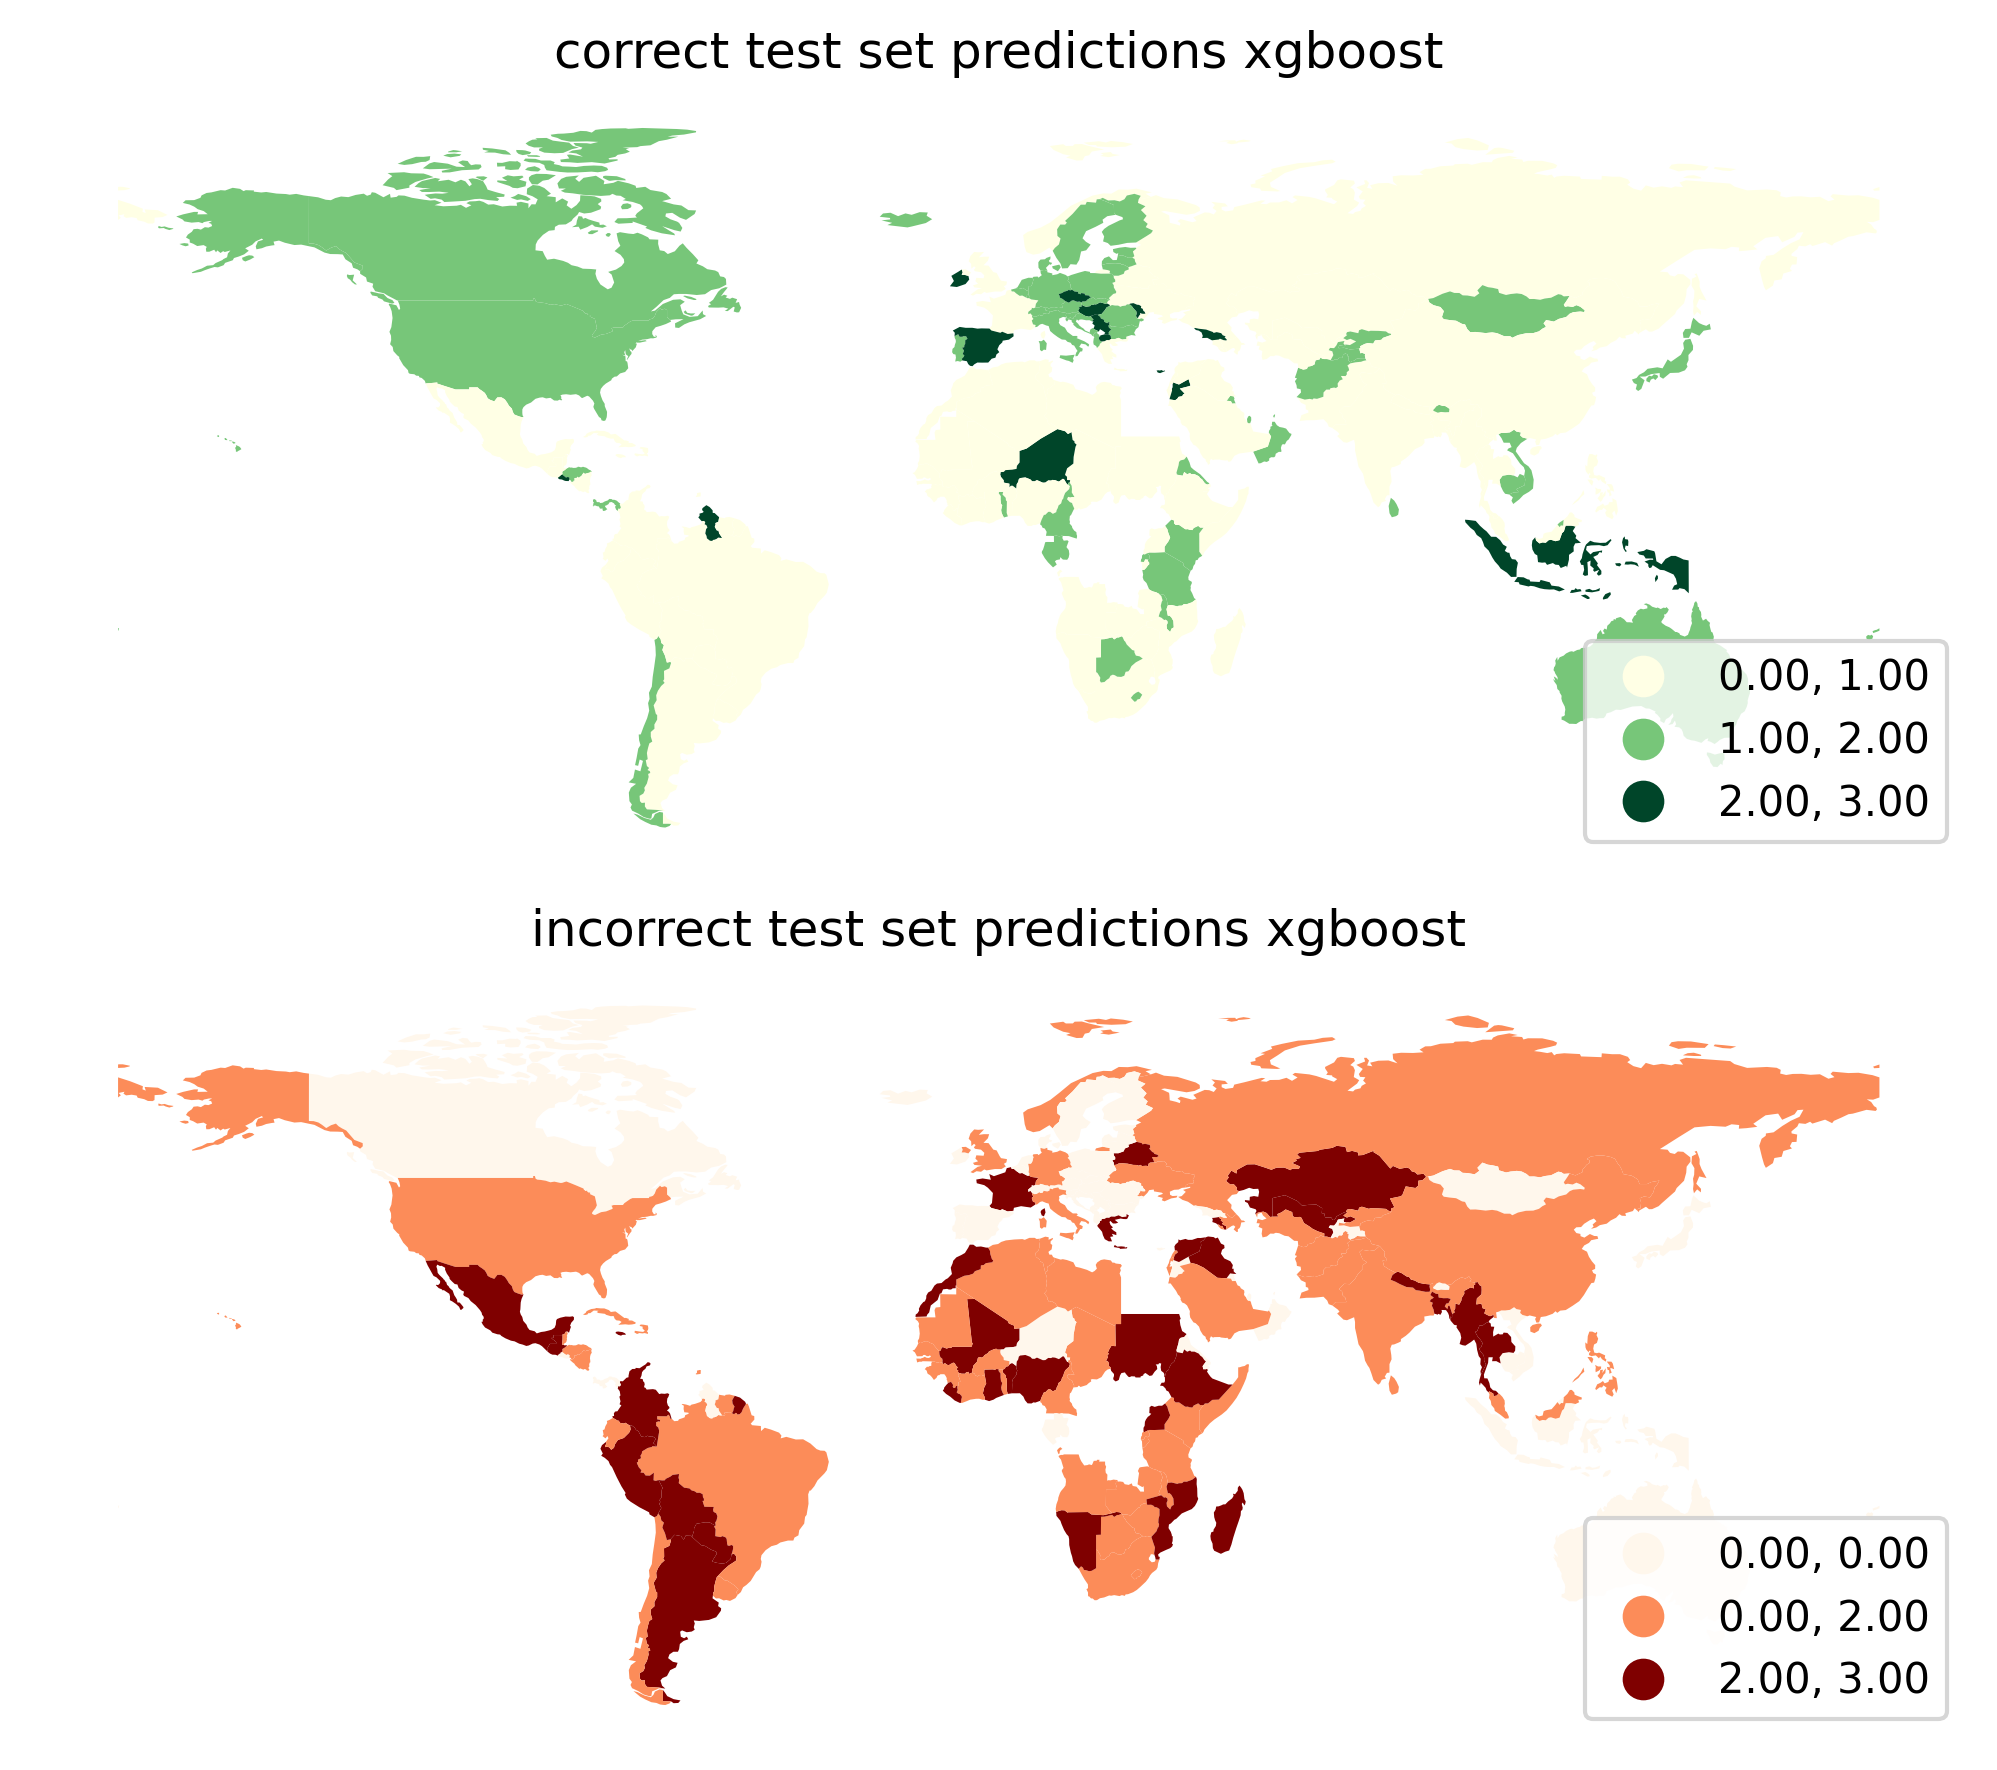

In [43]:
for m, df in df_pc.groupby('model'):
    fig, axes = plt.subplots(2, 1, figsize=(8, 6), dpi=300)
    axes[0].set_title(f"correct test set predictions {m}")
    df.plot(column='correct', ax=axes[0], scheme='QUANTILES', k=3,
            legend=True, legend_kwds={'loc': 'lower right'}, cmap="YlGn",
            missing_kwds={'color': 'lightgrey'})
    axes[1].set_title(f"incorrect test set predictions {m}")
    df.plot(column='incorrect', ax=axes[1], scheme='QUANTILES', k=3,
            legend=True, legend_kwds={'loc': 'lower right'}, cmap="OrRd",
            missing_kwds={'color': 'lightgrey'})
    axes[0].set_axis_off()
    axes[1].set_axis_off()
    fig.tight_layout()
    plt.savefig(f'imgs/fig-{m}-test-predictions.png')

In [44]:
#df_pc

In [45]:
adf = pd.read_csv(f"gcs://frsght/acled_labels/ACLED_Labels_042823_plus_l.csv", low_memory=False)[['fips','Under-five mortality rate 2021',
       'Adolescent population 2020 Proportion of total population (%) Total',
       'High', 'Low',
       'Medium', 'Very High', 'Alert', 'Stable', 'Sustainable', 'Warning',
       'High income', 'Low income', 'Lower middle income',
       'Upper middle income',]]

In [46]:
def make_country_name_mapper(location_column_name):
    # TODO caller needs a way to find out what `location_column_names` are possible
    # and/or we should match shorthands like
    # {'unicef': 'UNICEFOU', 'iso3': 'ISO3 (geonames)'}
    territory_identifiers = pd.read_csv("gcs://frsght/datasets/country_codes.csv")

    class CountryNameMapper:
        # TODO add docstring
        def __init__(self, location_column_name, codes):
            self.map = dict()
        
            # these columns have country name strings in various formats
            ccode_name_cols = ['Country or Area_en (M49)', 'English Short (unterm)',
                               'English Formal (unterm)', 'name_short (exio-wiod-eora)',
                               'name_official (exio-wiod-eora)', 'Short name (fao)',
                               'Official name (fao)', 'Country (geonames)']

            # make mapping of all various country name formats to desired location_column_name contents
            for country_name_col in ccode_name_cols:
                self.map.update(dict(codes[[country_name_col, location_column_name]].dropna().values))
            print(len(self.map.keys()))
        
        def __call__(self, location_name):
            # TODO would we ever want to return the original location_name
            # rather than empty string when no mapping is found?
            # should make_location_name_mapper take some kind of 'missing value handler' parameter?
            return self.map.get(location_name, '')
        
    return CountryNameMapper(location_column_name, territory_identifiers)

In [47]:
fips_mapper = make_country_name_mapper('fips (geonames)')

638


In [48]:
co = pd.read_csv("gcs://frsght/datasets/co-typology.csv")

In [49]:
co.columns.values

array(['Region', 'Business Area', 'Income Group', 'Utilization',
       'Utilization category', 'Cash Transfer', '# IPs', 'Staff',
       'Fragility', 'Emergency', 'Hum - Dev', 'Competitiveness', 'Gender',
       'HDI', 'Population size'], dtype=object)

In [50]:
co['fips'] = co['Business Area'].map(fips_mapper)

In [51]:
_df_pc = df_pc.merge(adf, left_on='fips', right_on='fips', how='inner')

In [52]:
_df_pc = _df_pc.merge(co[['fips', 'Fragility', 'Income Group', 'HDI', 'Region']], left_on='fips', right_on='fips', how='inner')

In [53]:
for col in ['model']:
    one_hot = pd.get_dummies(_df_pc[col].astype('string'))
    one_hot = one_hot.rename(columns=dict([(n, f'{col}-{n}') for n in range(4)]))
    _df_pc = _df_pc.merge(one_hot, left_index=True, right_index=True)

In [54]:
pd.options.display.float_format = "{:,.2f}".format
pd.set_option('display.max_rows', 1000)

In [55]:
_name = _df_pc.groupby(['model']).sum(numeric_only=True)[['correct_true', 'incorrect_true', 'correct_false', 'incorrect_false', ]]
_name['ratio_true'] = _name['correct_true'] / (_name['incorrect_true'])
_name['ratio_false'] = _name['correct_false'] / (_name['incorrect_false'])
_name

correct_true  incorrect_true  correct_false  incorrect_false  \
model                                                                       
ffnn             6,294.00        3,672.00      16,398.00        19,047.00   
transformer      6,156.00        3,810.00      18,078.00        17,367.00   
xgboost          6,876.00        1,863.00       9,606.00        27,066.00   

             ratio_true  ratio_false  
model                                 
ffnn               1.71         0.86  
transformer        1.62         1.04  
xgboost            3.69         0.35

HDI


correct  incorrect  correct_true  \
model       HDI                                                             
ffnn        Very high human development     1695        162          0.00   
            High human development          8952       2028          0.00   
transformer Very high human development     1191        666         63.00   
ffnn        Medium human development        6666       5109      1,734.00   
transformer Low human development          11073       8781      2,985.00   
            High human development          6006       4974        900.00   
            Medium human development        5964       5811      2,208.00   
xgboost     Very high human development      903        954          0.00   
            High human development          5208       5772      1,716.00   
            Medium human development        3858       7917      2,577.00   
            Low human development           6198      13656      2,268.00   
ffnn        Low human development           5379      14475      4,560.00   

                                         incorrect_true  correct_false  \
model       HDI                                                          
ffnn        Very high human development          162.00       1,695.00   
            High human development             2,028.00       8,952.00   
transformer Very high human development           99.00       1,128.00   
ffnn        Medium human development           1,482.00       4,932.00   
transformer Low human development              1,575.00       8,088.00   
            High human development             1,128.00       5,106.00   
            Medium human development           1,008.00       3,756.00   
xgboost     Very high human development          225.00         903.00   
            High human development               693.00       3,492.00   
            Medium human development             630.00       1,281.00   
            Low human development                315.00       3,930.00   
ffnn        Low human development                  0.00         819.00   

                                         incorrect_false  ratio  ratio_true  \
model       HDI                                                               
ffnn        Very high human development             0.00  10.46        0.00   
            High human development                  0.00   4.41        0.00   
transformer Very high human development           567.00   1.79        0.64   
ffnn        Medium human development            3,627.00   1.30        1.17   
transformer Low human development               7,206.00   1.26        1.90   
            High human development              3,846.00   1.21        0.80   
            Medium human development            4,803.00   1.03        2.19   
xgboost     Very high human development           729.00   0.95        0.00   
            High human development              5,079.00   0.90        2.48   
            Medium human development            7,287.00   0.49        4.09   
            Low human development              13,341.00   0.45        7.20   
ffnn        Low human development              14,475.00   0.37         inf   

                                         ratio_false  
model       HDI                                       
ffnn        Very high human development          inf  
            High human development               inf  
transformer Very high human development         1.99  
ffnn        Medium human development            1.36  
transformer Low human development               1.12  
            High human development              1.33  
            Medium human development            0.78  
xgboost     Very high human development         1.24  
            High human development              0.69  
            Medium human development            0.18  
            Low human development               0.29  
ffnn        Low human development               0.06

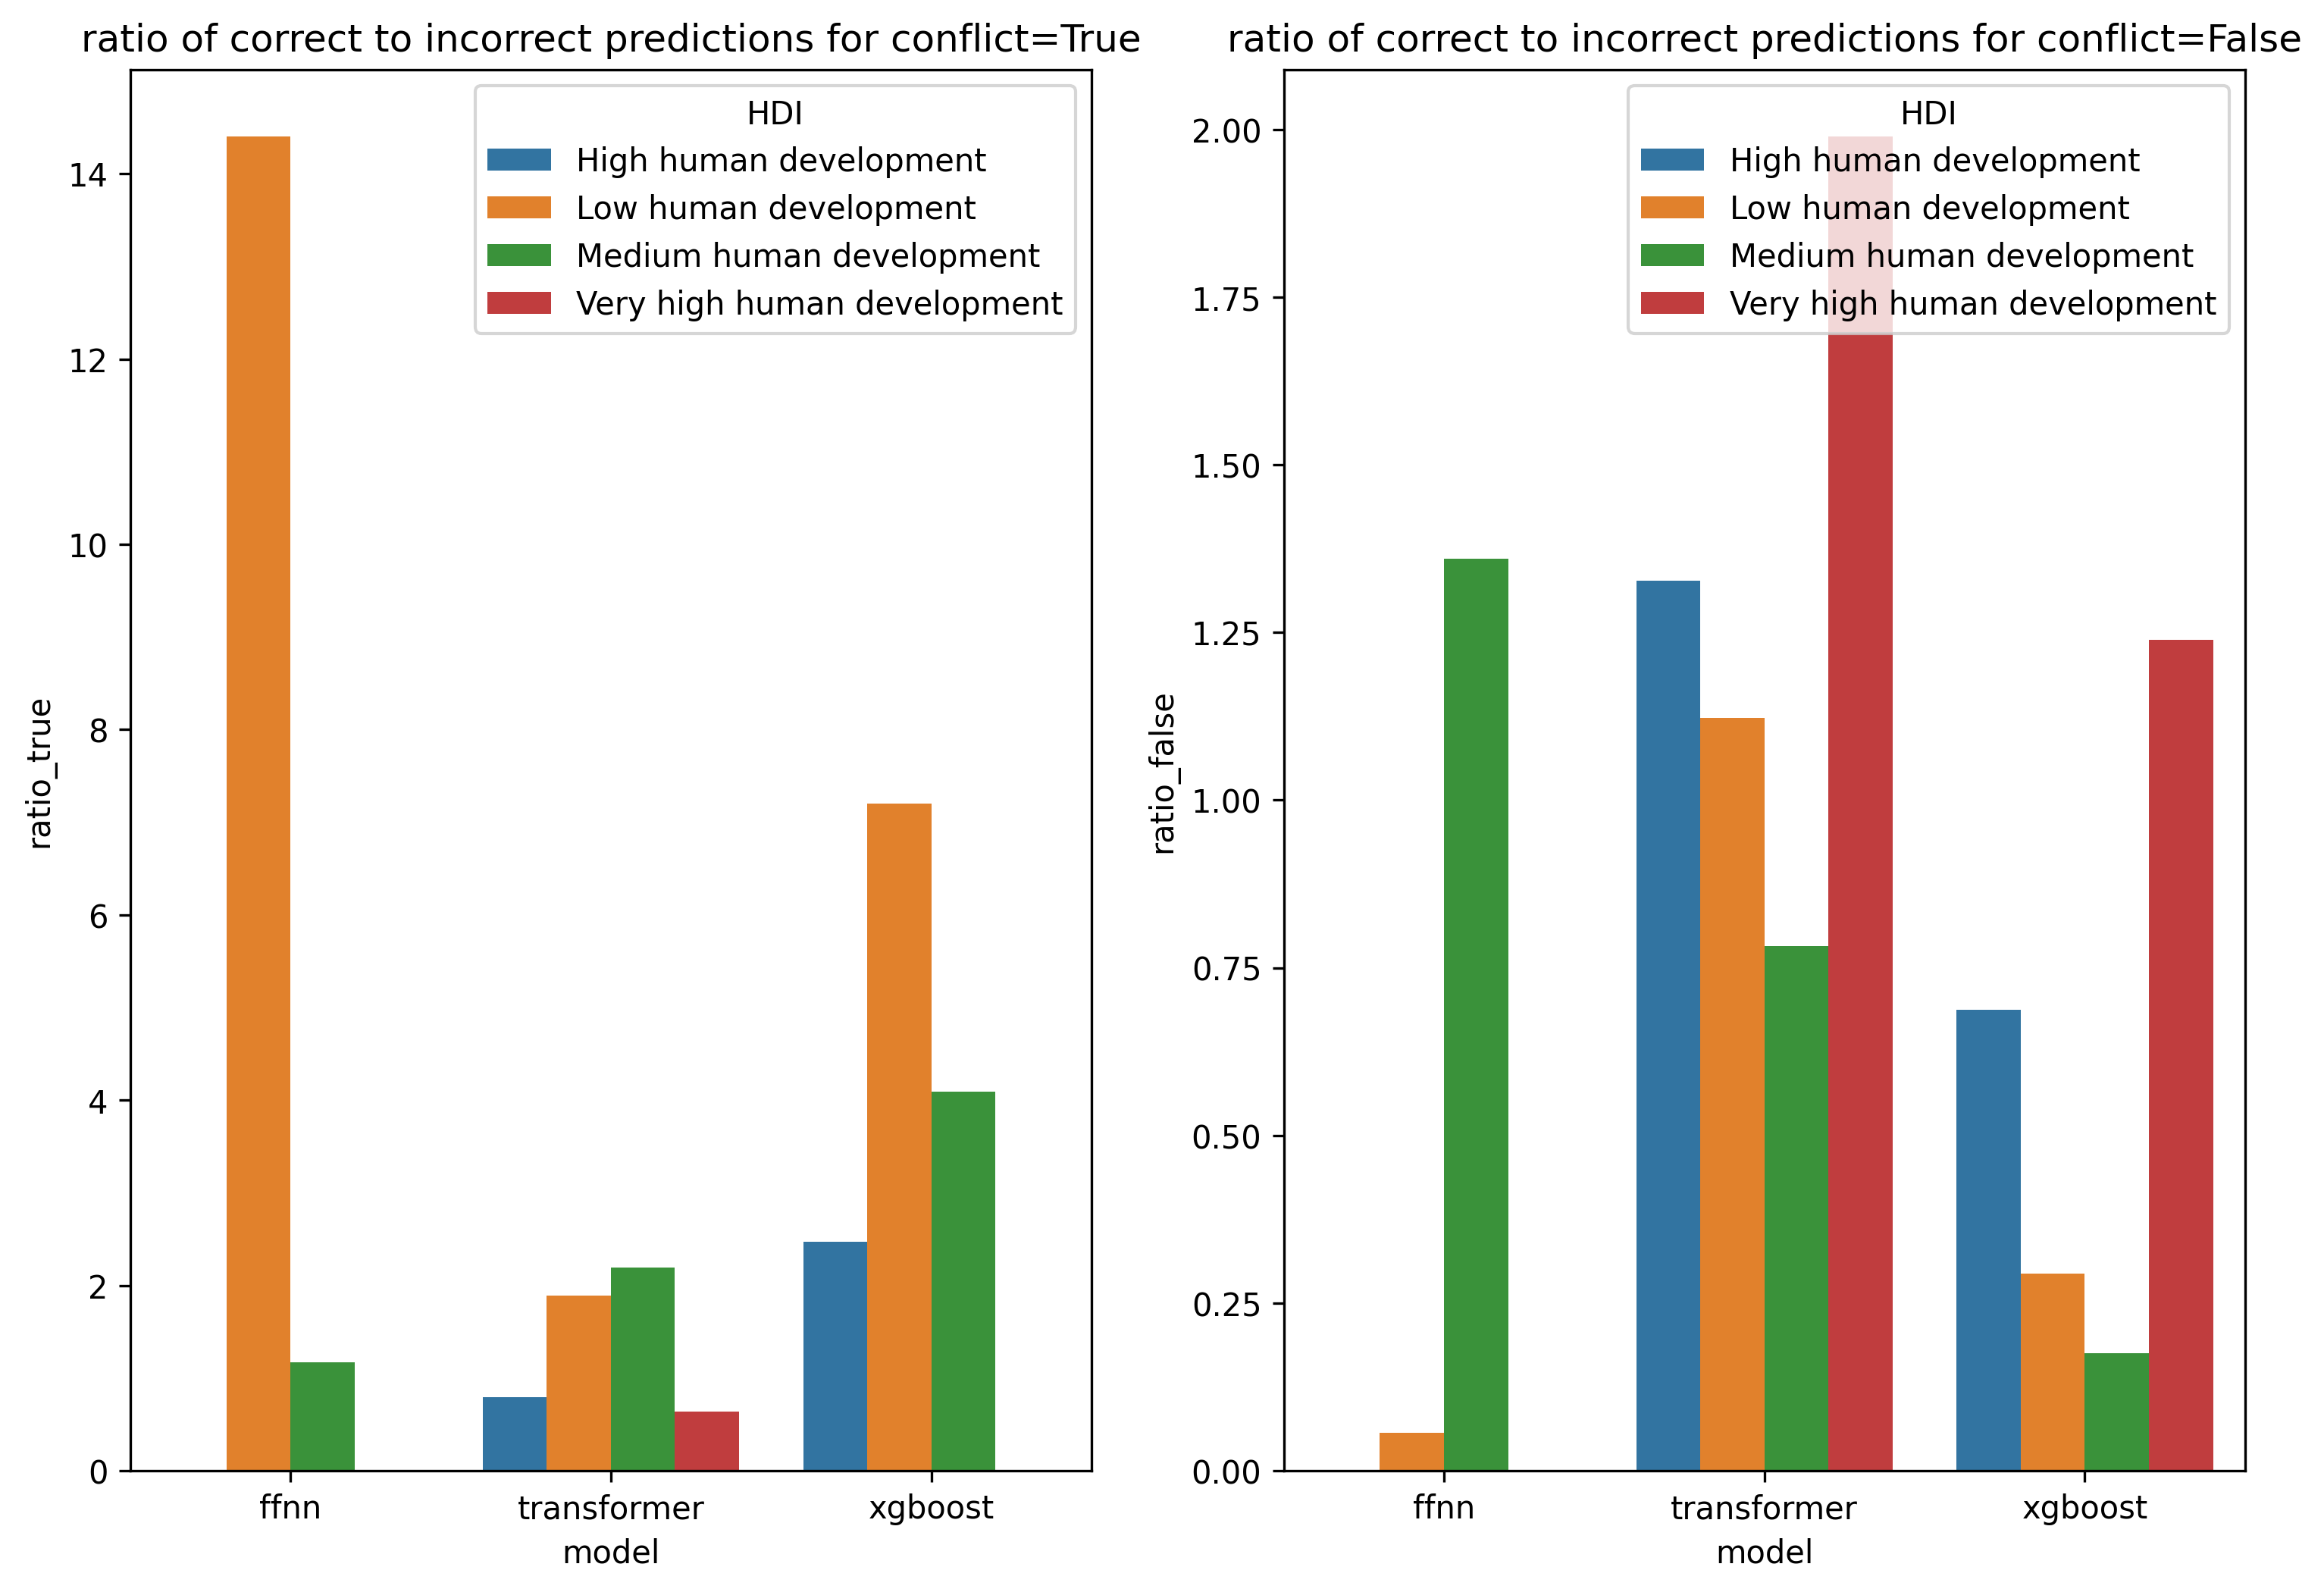

Income Group


correct  incorrect  correct_true  \
model       Income Group                                            
ffnn        High income             1065        162          0.00   
transformer High income             1002        225         63.00   
ffnn        Upper middle income     8613       2034          0.00   
xgboost     High income              714        513          0.00   
ffnn        Lower middle income     7665       6675      2,049.00   
transformer Upper middle income     5604       5043        750.00   
            Low income             10098       9099      3,144.00   
            Lower middle income     7530       6810      2,199.00   
xgboost     Lower middle income     5442       8898      2,859.00   
            Upper middle income     4002       6645      1,308.00   
            Low income              6324      12873      2,709.00   
ffnn        Low income              5349      13848      4,245.00   

                                 incorrect_true  correct_false  \
model       Income Group                                         
ffnn        High income                  162.00       1,065.00   
transformer High income                   99.00         939.00   
ffnn        Upper middle income        2,034.00       8,613.00   
xgboost     High income                  225.00         714.00   
ffnn        Lower middle income        1,317.00       5,616.00   
transformer Upper middle income        1,284.00       4,854.00   
            Low income                 1,260.00       6,954.00   
            Lower middle income        1,167.00       5,331.00   
xgboost     Lower middle income          378.00       2,583.00   
            Upper middle income        1,260.00       2,694.00   
            Low income                     0.00       3,615.00   
ffnn        Low income                   159.00       1,104.00   

                                 incorrect_false  ratio  ratio_true  \
model       Income Group                                              
ffnn        High income                     0.00   6.57        0.00   
transformer High income                   126.00   4.45        0.64   
ffnn        Upper middle income             0.00   4.23        0.00   
xgboost     High income                   288.00   1.39        0.00   
ffnn        Lower middle income         5,358.00   1.15        1.56   
transformer Upper middle income         3,759.00   1.11        0.58   
            Low income                  7,839.00   1.11        2.50   
            Lower middle income         5,643.00   1.11        1.88   
xgboost     Lower middle income         8,520.00   0.61        7.56   
            Upper middle income         5,385.00   0.60        1.04   
            Low income                 12,873.00   0.49         inf   
ffnn        Low income                 13,689.00   0.39       26.70   

                                 ratio_false  
model       Income Group                      
ffnn        High income                  inf  
transformer High income                 7.45  
ffnn        Upper middle income          inf  
xgboost     High income                 2.48  
ffnn        Lower middle income         1.05  
transformer Upper middle income         1.29  
            Low income                  0.89  
            Lower middle income         0.94  
xgboost     Lower middle income         0.30  
            Upper middle income         0.50  
            Low income                  0.28  
ffnn        Low income                  0.08

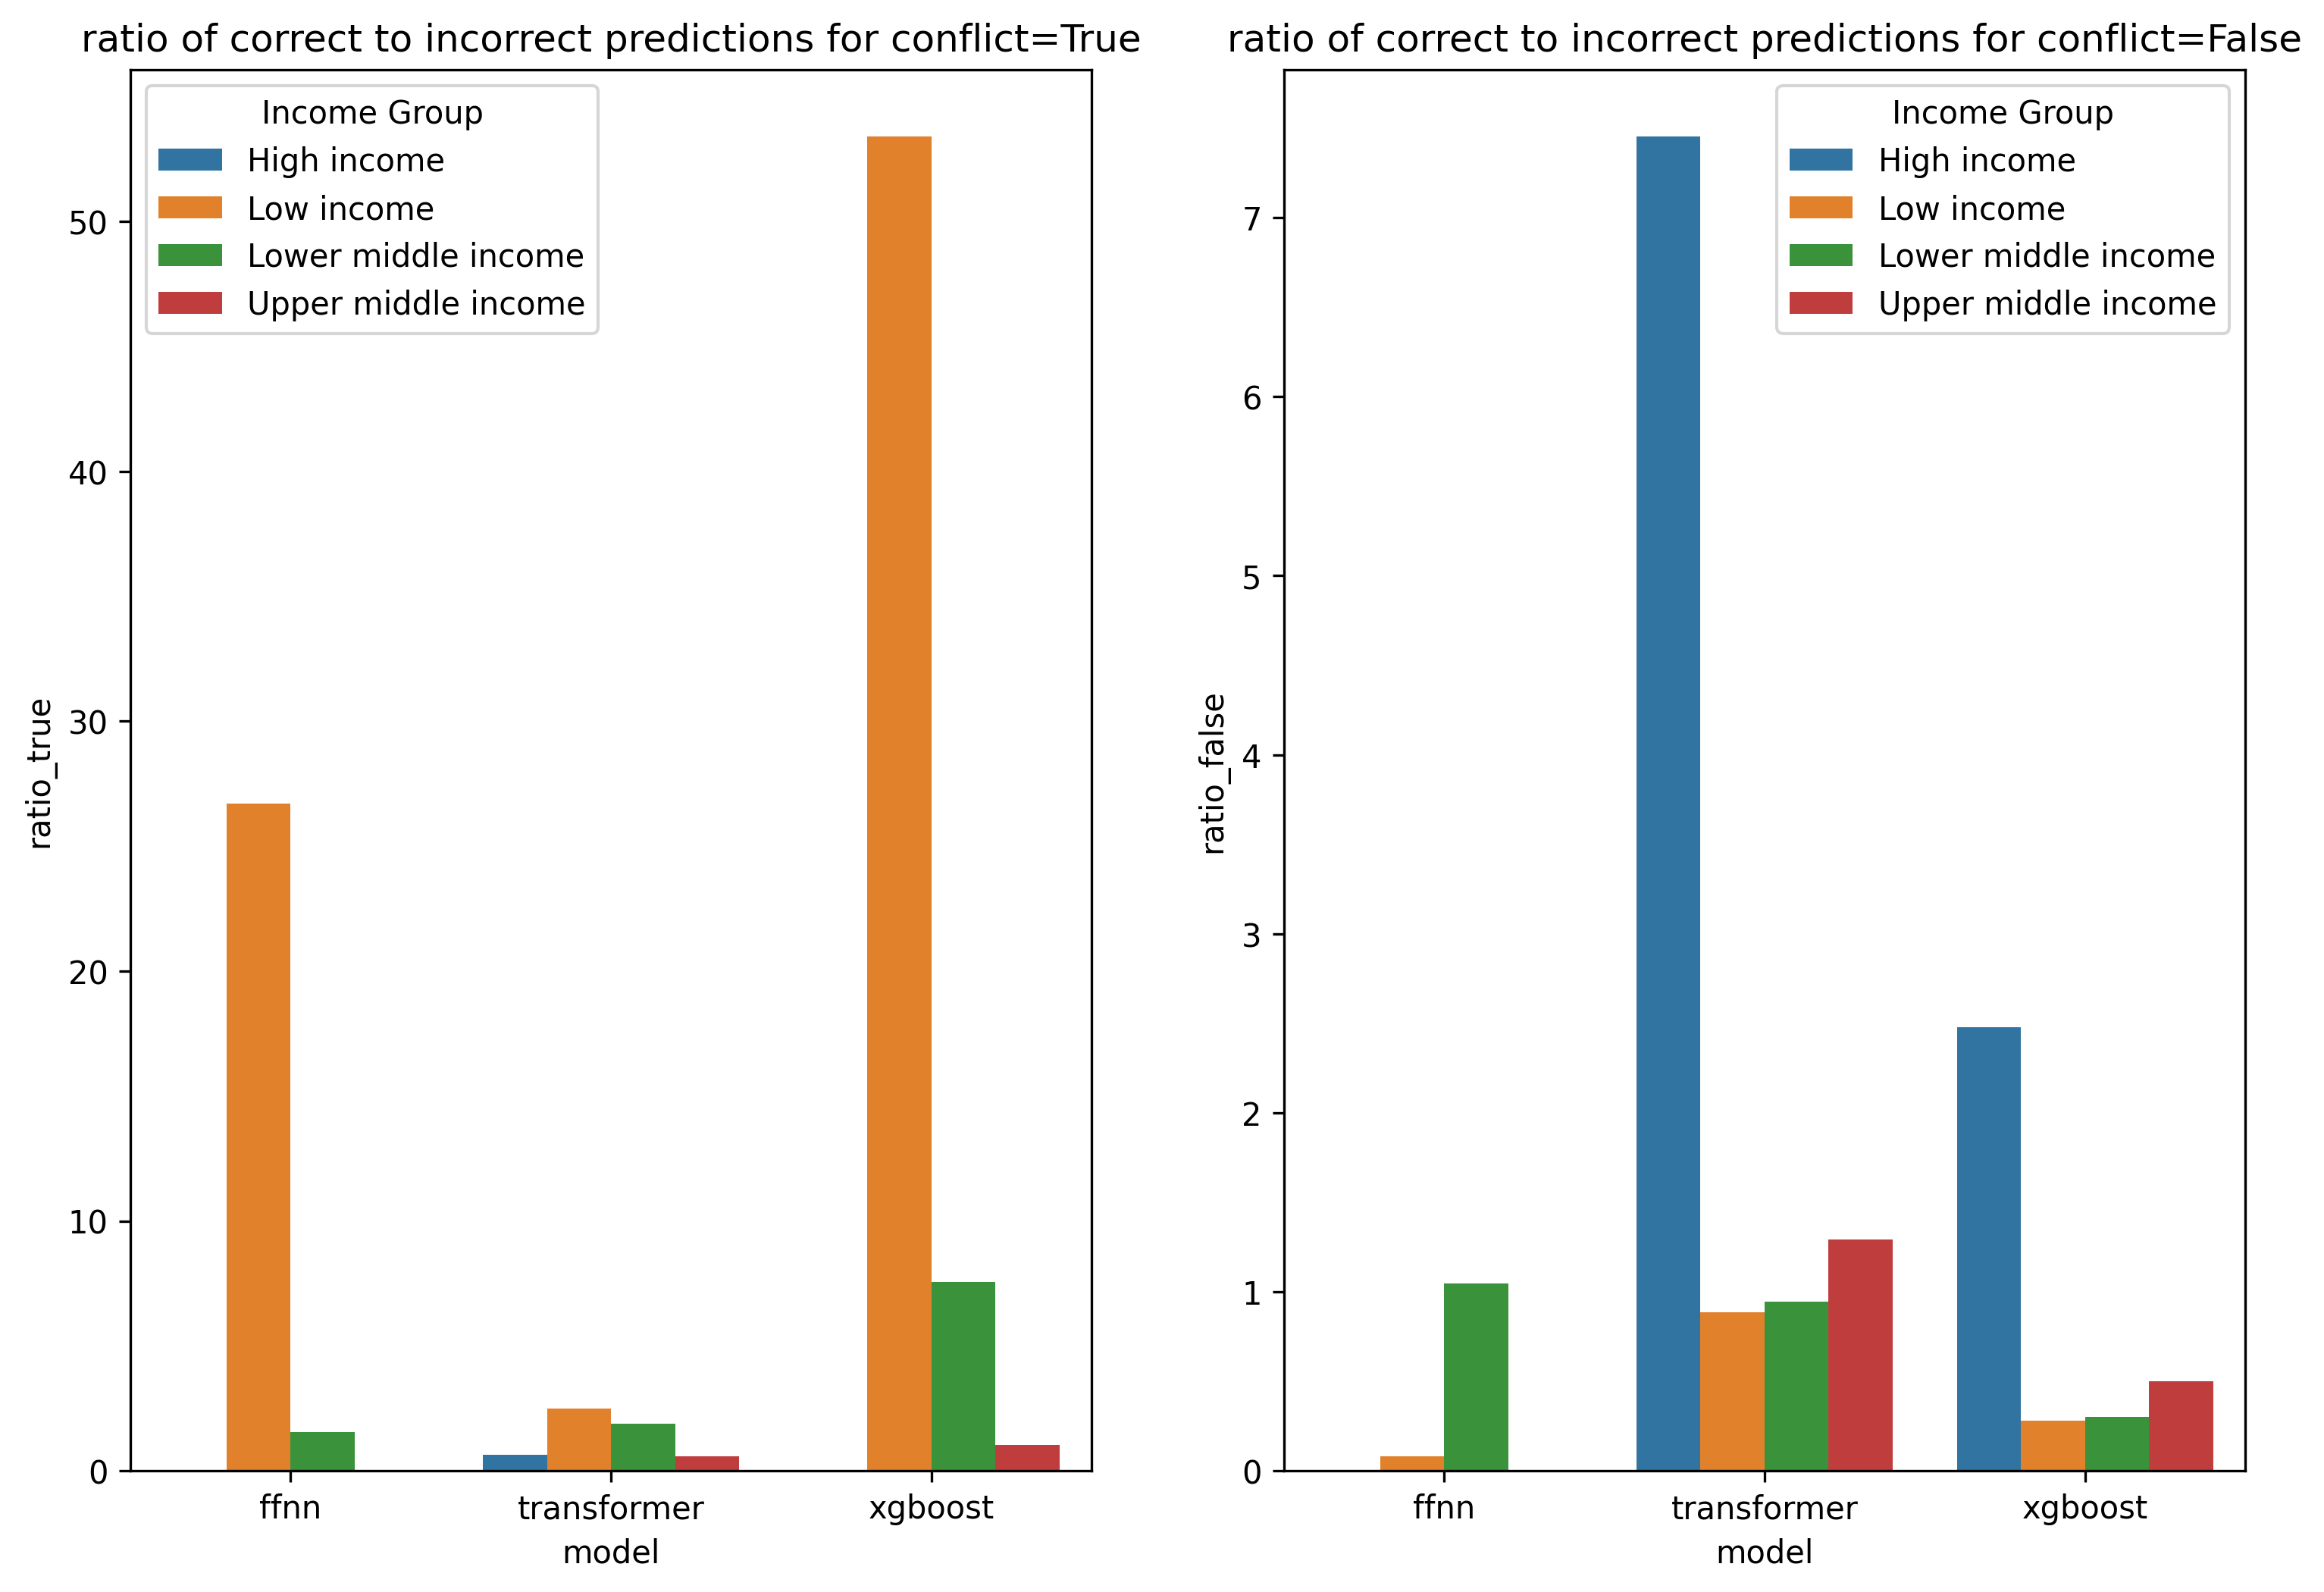

Fragility


correct  incorrect  correct_true  incorrect_true  \
model       Fragility                                                     
ffnn        Stable        2001        378          0.00          378.00   
transformer Stable        1938        441         63.00          315.00   
xgboost     Stable        1749        630        315.00          126.00   
ffnn        Warning      15675      10383      3,465.00        3,294.00   
transformer Warning      14667      11391      3,264.00        3,495.00   
            Alert         7629       9345      2,829.00            0.00   
xgboost     Warning       9636      16422      4,449.00        1,422.00   
            Alert         5097      11877      2,112.00          315.00   
ffnn        Alert         5016      11958      2,829.00            0.00   

                       correct_false  incorrect_false  ratio  ratio_true  \
model       Fragility                                                      
ffnn        Stable          2,001.00             0.00   5.29        0.00   
transformer Stable          1,875.00           126.00   4.39        0.20   
xgboost     Stable          1,434.00           504.00   2.78        2.50   
ffnn        Warning        12,210.00         7,089.00   1.51        1.05   
transformer Warning        11,403.00         7,896.00   1.29        0.93   
            Alert           4,800.00         9,345.00   0.82         inf   
xgboost     Warning         5,187.00        15,000.00   0.59        3.13   
            Alert           2,985.00        11,562.00   0.43        6.70   
ffnn        Alert           2,187.00        11,958.00   0.42         inf   

                       ratio_false  
model       Fragility               
ffnn        Stable             inf  
transformer Stable           14.88  
xgboost     Stable            2.85  
ffnn        Warning           1.72  
transformer Warning           1.44  
            Alert             0.51  
xgboost     Warning           0.35  
            Alert             0.26  
ffnn        Alert             0.18

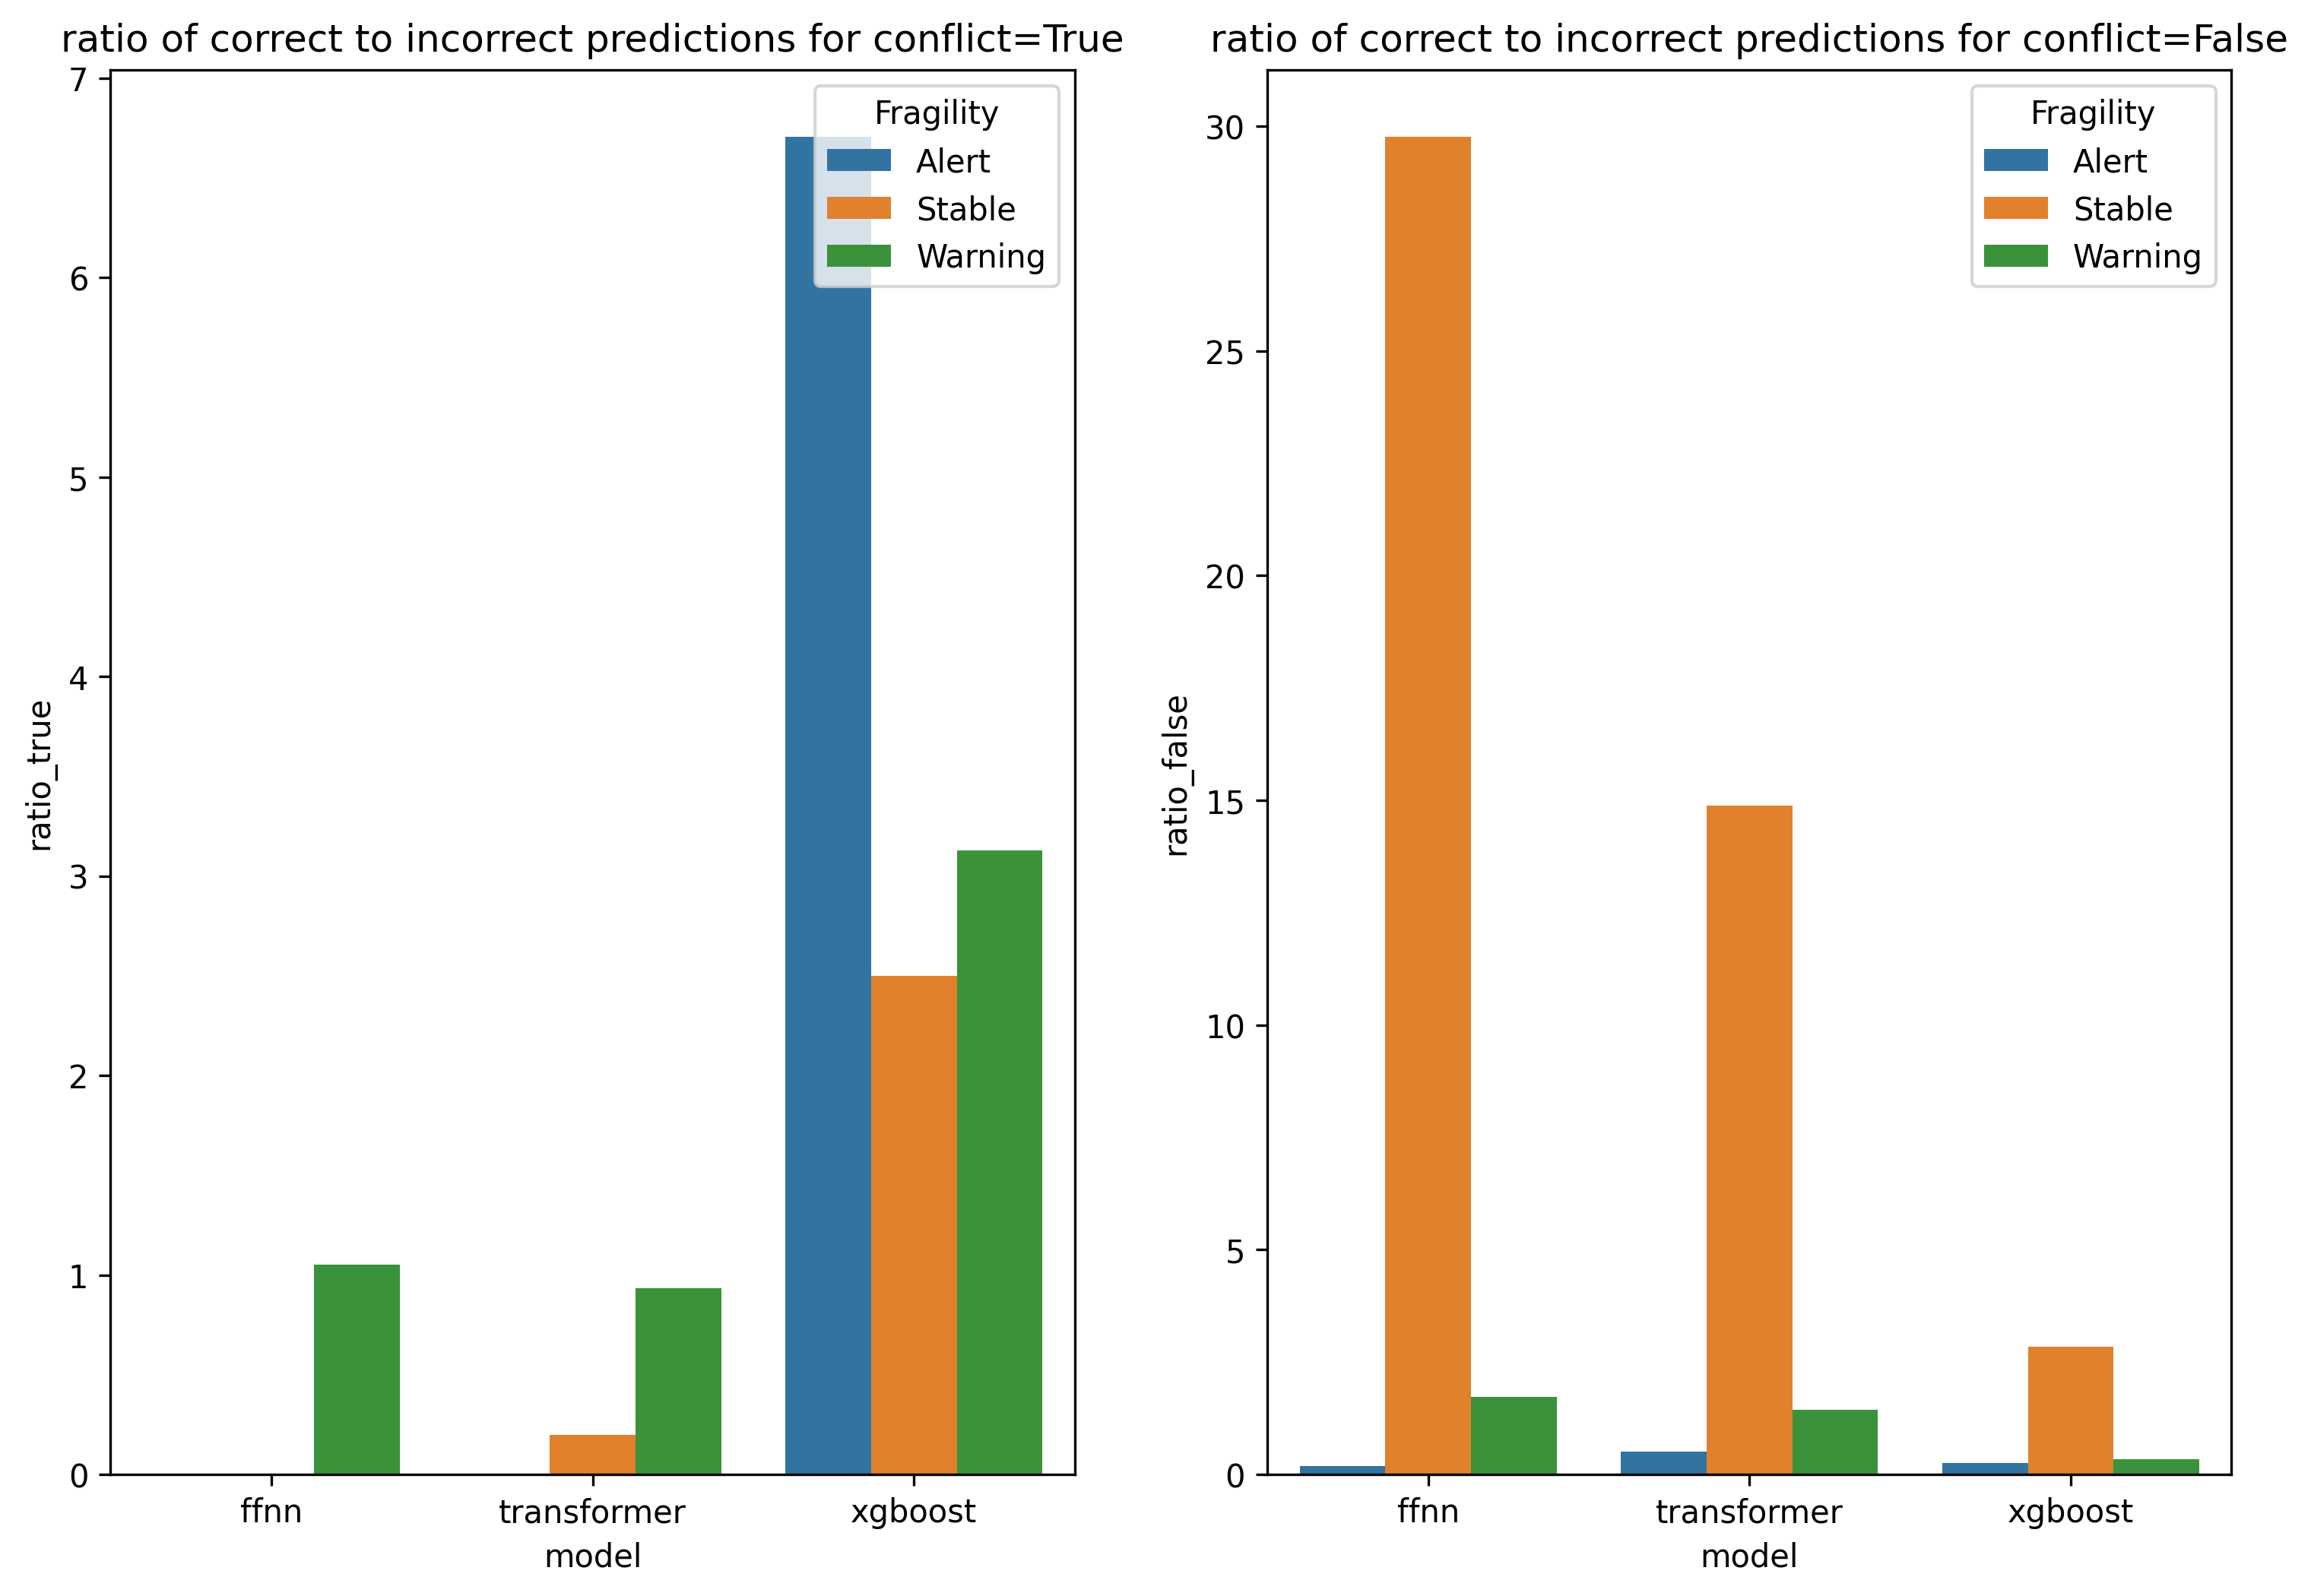

continent


correct  incorrect  correct_true  incorrect_true  \
model       continent                                                         
ffnn        Europe            1386         63          0.00           63.00   
            North America     1575        252          0.00          252.00   
            South America     1575        252          0.00          252.00   
transformer Europe            1134        315         63.00            0.00   
xgboost     Europe            1134        315         63.00            0.00   
ffnn        Asia              5871       1677        309.00          900.00   
transformer North America     1197        630         63.00          189.00   
            South America     1008        819        126.00          126.00   
            Africa           17010      15750      5,040.00        3,150.00   
            Asia              3885       3663        864.00          345.00   
xgboost     Asia              3126       4422      1,017.00           99.00   
            North America      693       1134         63.00          189.00   
ffnn        Africa           12285      20475      5,985.00        2,205.00   
xgboost     Africa           11025      21735      5,670.00        1,260.00   
            South America      504       1323         63.00          315.00   

                           correct_false  incorrect_false  ratio  ratio_true  \
model       continent                                                          
ffnn        Europe              1,386.00             0.00  22.00        0.00   
            North America       1,575.00             0.00   6.25        0.00   
            South America       1,575.00             0.00   6.25        0.00   
transformer Europe              1,071.00           315.00   3.60         inf   
xgboost     Europe              1,071.00           315.00   3.60         inf   
ffnn        Asia                5,562.00           777.00   3.50        0.34   
transformer North America       1,134.00           441.00   1.90        0.33   
            South America         882.00           693.00   1.23        1.00   
            Africa             11,970.00        12,600.00   1.08        1.60   
            Asia                3,021.00         3,318.00   1.06        2.50   
xgboost     Asia                2,109.00         4,323.00   0.71       10.27   
            North America         630.00           945.00   0.61        0.33   
ffnn        Africa              6,300.00        18,270.00   0.60        2.71   
xgboost     Africa              5,355.00        20,475.00   0.51        4.50   
            South America         441.00         1,008.00   0.38        0.20   

                           ratio_false  
model       continent                   
ffnn        Europe                 inf  
            North America          inf  
            South America          inf  
transformer Europe                3.40  
xgboost     Europe                3.40  
ffnn        Asia                  7.16  
transformer North America         2.57  
            South America         1.27  
            Africa                0.95  
            Asia                  0.91  
xgboost     Asia                  0.49  
            North America         0.67  
ffnn        Africa                0.34  
xgboost     Africa                0.26  
            South America         0.44

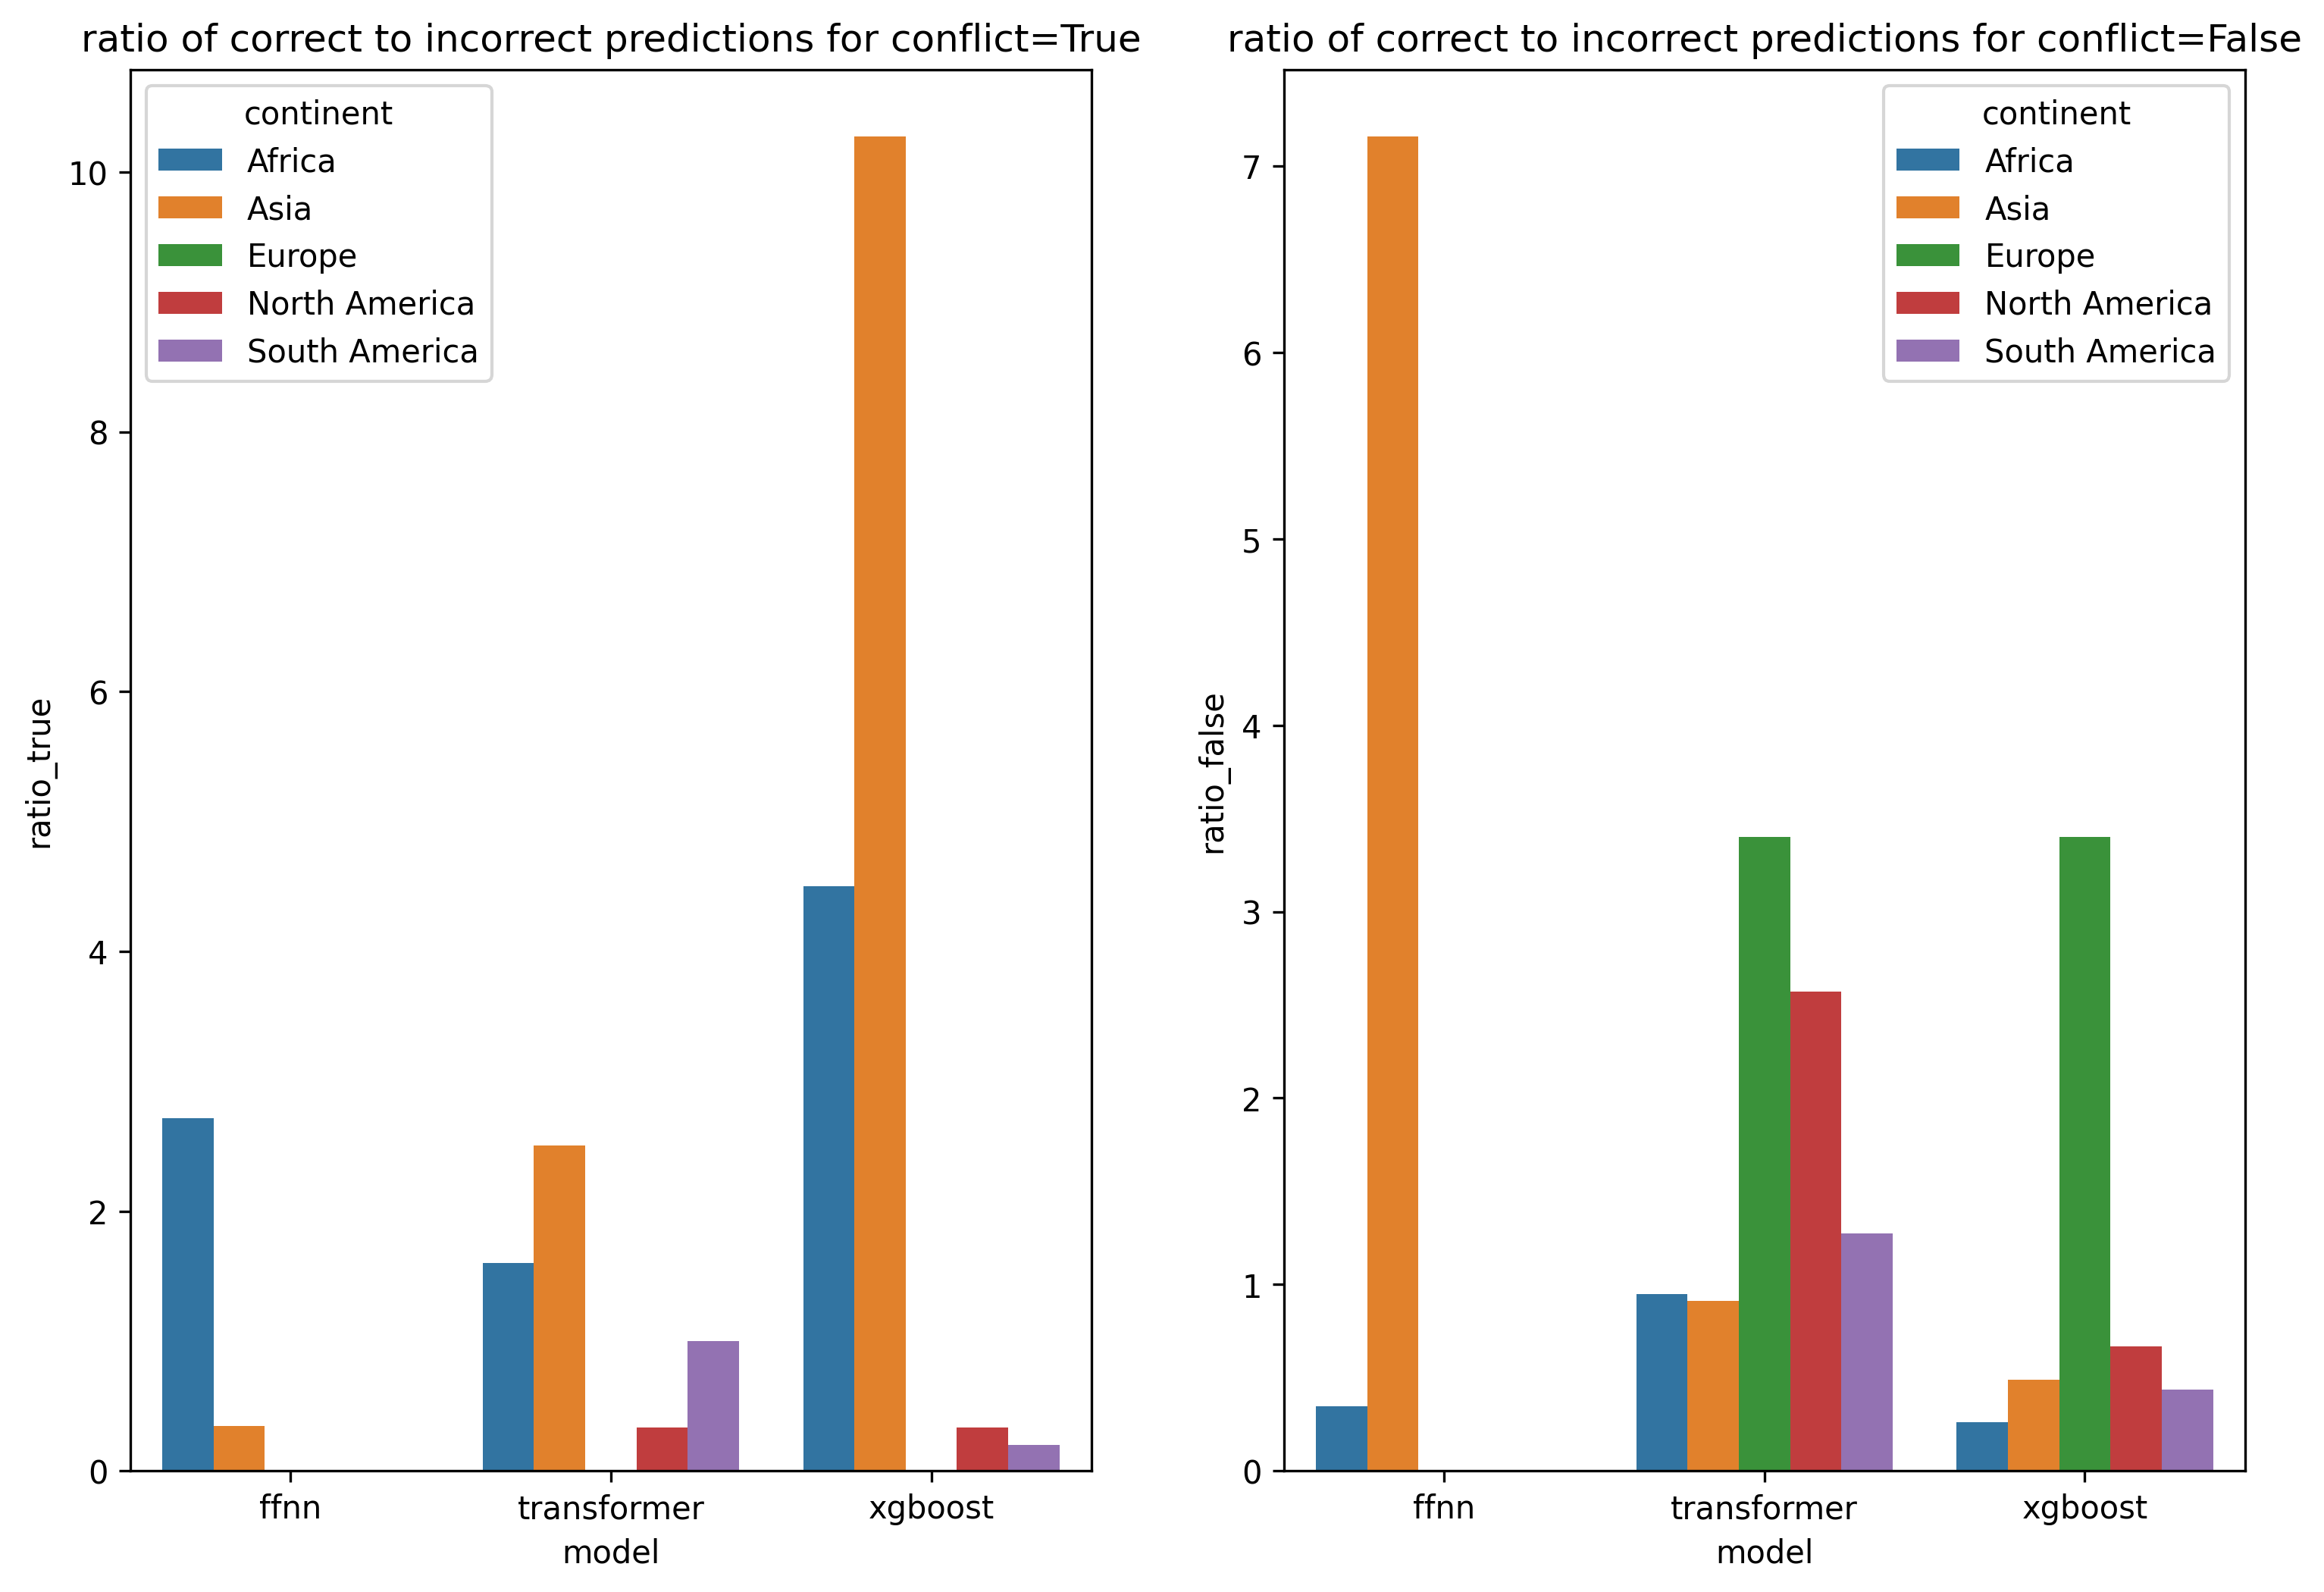

Region


correct  incorrect  correct_true  incorrect_true  \
model       Region                                                     
ffnn        ECAR       2394         63          0.00           63.00   
            EAPR       2280        309          0.00          309.00   
            LACR       3150        504          0.00          504.00   
            MENAR      4596       1608        150.00          903.00   
transformer EAPR       1686        903        309.00            0.00   
xgboost     ECAR       1575        882        252.00            0.00   
transformer ECAR       1512        945         63.00            0.00   
            LACR       2205       1449        189.00          315.00   
ffnn        SAR        1452       1020        159.00          318.00   
transformer ESAR       8820       6615      2,520.00        1,575.00   
            WCAR       6930       5670      2,205.00        1,260.00   
xgboost     EAPR       1272       1317        249.00            0.00   
            ESAR       5670       9765      3,780.00          945.00   
transformer MENAR      2217       3987        552.00          501.00   
            SAR         864       1608        318.00          159.00   
xgboost     LACR       1197       2457        126.00          504.00   
ffnn        ESAR       5040      10395      3,150.00          945.00   
xgboost     WCAR       4095       8505      1,575.00          315.00   
            SAR         792       1680        405.00            0.00   
            MENAR      1881       4323        489.00           99.00   
ffnn        WCAR       3780       8820      2,835.00          630.00   

                    correct_false  incorrect_false  ratio  ratio_true  \
model       Region                                                      
ffnn        ECAR         2,394.00             0.00  38.00        0.00   
            EAPR         2,280.00             0.00   7.38        0.00   
            LACR         3,150.00             0.00   6.25        0.00   
            MENAR        4,446.00           705.00   2.86        0.17   
transformer EAPR         1,377.00           903.00   1.87         inf   
xgboost     ECAR         1,323.00           882.00   1.79         inf   
transformer ECAR         1,449.00           945.00   1.60         inf   
            LACR         2,016.00         1,134.00   1.52        0.60   
ffnn        SAR          1,293.00           702.00   1.42        0.50   
transformer ESAR         6,300.00         5,040.00   1.33        1.60   
            WCAR         4,725.00         4,410.00   1.22        1.75   
xgboost     EAPR         1,023.00         1,317.00   0.97         inf   
            ESAR         1,890.00         8,820.00   0.58        4.00   
transformer MENAR        1,665.00         3,486.00   0.56        1.10   
            SAR            546.00         1,449.00   0.54        2.00   
xgboost     LACR         1,071.00         1,953.00   0.49        0.25   
ffnn        ESAR         1,890.00         9,450.00   0.48        3.33   
xgboost     WCAR         2,520.00         8,190.00   0.48        5.00   
            SAR            387.00         1,680.00   0.47         inf   
            MENAR        1,392.00         4,224.00   0.44        4.94   
ffnn        WCAR           945.00         8,190.00   0.43        4.50   

                    ratio_false  
model       Region               
ffnn        ECAR            inf  
            EAPR            inf  
            LACR            inf  
            MENAR          6.31  
transformer EAPR           1.52  
xgboost     ECAR           1.50  
transformer ECAR           1.53  
            LACR           1.78  
ffnn        SAR            1.84  
transformer ESAR           1.25  
            WCAR           1.07  
xgboost     EAPR           0.78  
            ESAR           0.21  
transformer MENAR          0.48  
            SAR            0.38  
xgboost     LACR           0.55  
ffnn        ESAR           0.20  
xgboost     WCAR           0.31  
   

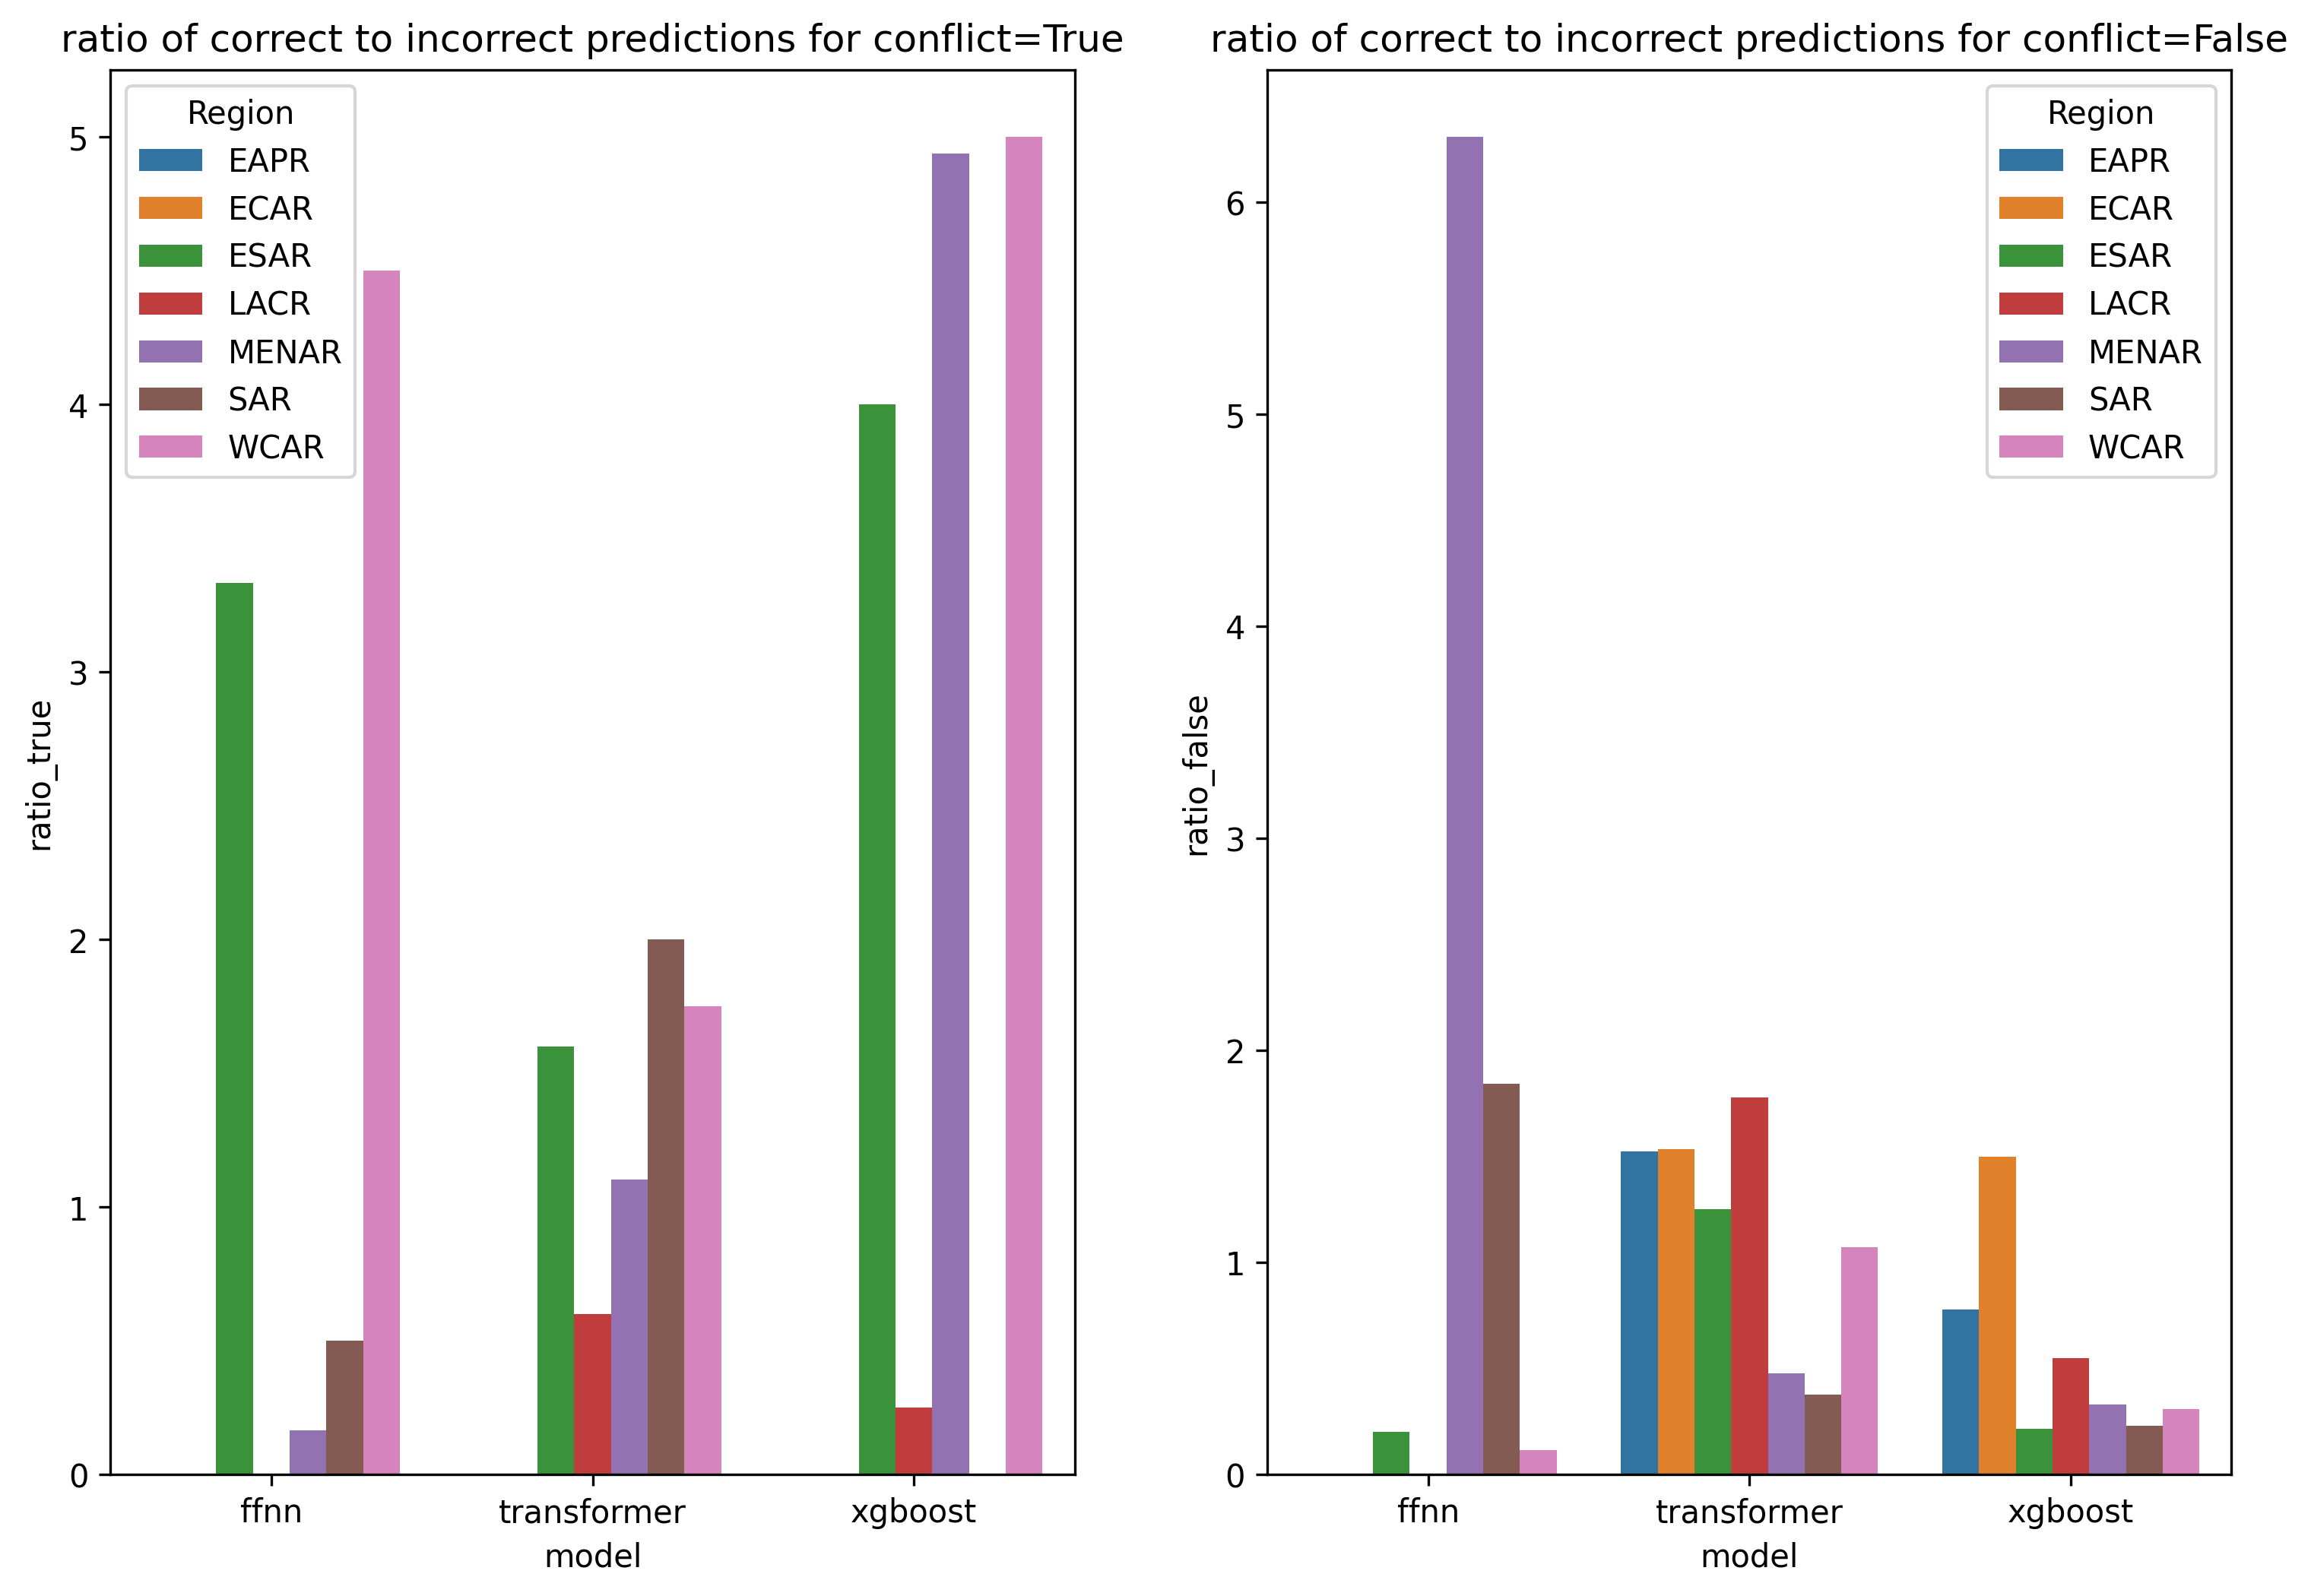

In [56]:
for dim in ['HDI', 'Income Group', 'Fragility', 'continent', 'Region',]:
    print(dim)
    df = _df_pc.groupby(['model', dim]).sum(numeric_only=True)[['correct', 'incorrect', 'correct_true', 'incorrect_true', 'correct_false', 'incorrect_false', ]]
    df['ratio'] = df['correct'] / (df['incorrect'])
    df['ratio_true'] = df['correct_true'] / (df['incorrect_true'])
    df['ratio_false'] = df['correct_false'] / (df['incorrect_false'])

    display(df.sort_values(by='ratio', ascending=False))
    df['ratio'] = df['ratio'].replace(np.inf, (df['ratio'].sort_values(ascending=False)[1]*2))
    df['ratio_true'] = df['ratio_true'].replace(np.inf, (df['ratio_true'].sort_values(ascending=False)[1]*2))
    df['ratio_false'] = df['ratio_false'].replace(np.inf, (df['ratio_false'].sort_values(ascending=False)[1]*2))

    df = df.reset_index()
    #sns.barplot(data=df, x=dim, y='ratio', hue='model')
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), dpi=300)
    ax[0].set_title('ratio of correct to incorrect predictions for conflict=True')
    sns.barplot(data=df, x='model', y='ratio_true', hue=dim, ax=ax[0])
    ax[1].set_title('ratio of correct to incorrect predictions for conflict=False')

    sns.barplot(data=df, x='model', y='ratio_false', hue=dim, ax=ax[1])
    plt.show()

In [57]:
# list of sklearn.metrics functions that expect args `y_true` and `y_pred`
# nice explanations here: https://neptune.ai/blog/evaluation-metrics-binary-classification
# cohen kappa: how much better is your model over the random classifier that predicts based on class frequencies
# matthews: a correlation between predicted classes and ground truth
bin_metrics = ['f1_score', 'precision_score', 'recall_score',
               'cohen_kappa_score', 'matthews_corrcoef']

out = list()

for m, df in dfs.items():
    for metric in bin_metrics:
        fun = operator.methodcaller(metric, df[meta[m]['y_true']],
                                    df[meta[m]['y_pred']])
        out.append((m, metric, fun(metrics), 'max'))
    out.append((m, 'roc_auc_score', metrics.roc_auc_score(df[meta[m]['y_true']],
                                                          df[meta[m]['y_pred_proba']]), 'max'))
    
    tn, fp, fn, tp = metrics.confusion_matrix(df[meta[m]['y_true']],
                                              df[meta[m]['y_pred']]).ravel()
    
    # how many predictions out of all positive predictions were incorrect
    false_discovery_rate = fp/ (tp + fp)
    out.append((m, 'false_discovery_rate', false_discovery_rate, 'min'))
    
    # how many observations predicted as positive are in fact positive
    positive_predictive_value = tp/ (tp + fp)
    out.append((m, 'positive_predictive_value', positive_predictive_value, 'max'))
    
    # how many predictions out of all negative predictions were correct
    negative_predictive_value = tn/ (tn + fn)
    out.append((m, 'negative_predictive_value', negative_predictive_value, 'max'))
       
    false_positive_rate = fp / (fp + tn)
    out.append((m, 'false_positive_rate', false_positive_rate, 'min'))
    
    false_negative_rate = fn / (tp + fn)
    out.append((m, 'false_negative_rate', false_negative_rate, 'min'))
    
    true_positive_rate = tp / (tp + fn)
    out.append((m, 'true_positive_rate', true_positive_rate, 'max'))
    
    true_negative_rate = tn / (tn + fp)
    out.append((m, 'true_negative_rate', true_negative_rate, 'max'))

In [58]:
max_best = ['true_negative_rate', 'negative_predictive_value', 'true_positive_rate',
            'positive_predictive_value', 'f1_score', 'precision_score',
            'recall_score', 'cohen_kappa_score', 'matthews_corrcoef' 'roc_auc_score',]
min_best = ['false_negative_rate', 'false_discovery_rate', 'false_positive_rate',]

In [59]:
mdisplay = {'ffnn': 'FFNN', 'xgboost': 'XGBoost', 'transformer': 'Transformer'}

In [60]:
model_metrics = pd.DataFrame(out, columns=('model', 'metric', 'value', 'best'))

In [61]:
model_metrics['metric'] = model_metrics['metric'].apply(lambda r: ' '.join(r.split('_')).title())

In [62]:
model_metrics['model'] = model_metrics['model'].map(mdisplay)

In [63]:
# max value for each metric
(model_metrics.loc[model_metrics[model_metrics.best=='max']
                   .groupby(["metric"])["value"]
                   .idxmax()][['metric', 'model', 'value']])

metric    model  value
29          Cohen Kappa Score     FFNN   0.18
26                   F1 Score     FFNN   0.33
30          Matthews Corrcoef     FFNN   0.18
21  Negative Predictive Value  XGBoost   0.92
33  Positive Predictive Value     FFNN   0.27
27            Precision Score     FFNN   0.27
15               Recall Score  XGBoost   0.72
18              Roc Auc Score  XGBoost   0.69
38         True Negative Rate     FFNN   0.81
24         True Positive Rate  XGBoost   0.72

In [64]:
# min value for each metric
(model_metrics.loc[model_metrics[model_metrics.best=='min']
                   .groupby(["metric"])["value"]
                   .idxmin()][['metric', 'model', 'value']])

metric    model  value
32  False Discovery Rate     FFNN   0.73
23   False Negative Rate  XGBoost   0.28
35   False Positive Rate     FFNN   0.19

In [65]:
#| label: tbl-best-min-metrics-broken
#| layout-ncol: 1

# TODO not only do styles not work, but this makes one article
# column narrower than the other one :(

cm = sns.light_palette("red", as_cmap=True)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styler-Object-and-Customising-the-Display
# TODO styles/colors still not working? https://github.com/quarto-dev/quarto-cli/discussions/3964
styler = (model_metrics[model_metrics.best=='min'][['metric', 'model', 'value']]
            .sort_values('metric')
            .style
                .background_gradient(cmap=cm)
                .format(precision=3)
                .hide(axis="index"))
dfi.export(styler, 'imgs/tbl-best-min-metrics.png')
styler

In [66]:
print(model_metrics[model_metrics.best=='min'][['metric', 'model', 'value']]
               .sort_values('metric').to_markdown(index=False, floatfmt=".02f"))

| metric               | model       |   value |
|:---------------------|:------------|--------:|
| False Discovery Rate | Transformer |    0.80 |
| False Discovery Rate | XGBoost     |    0.83 |
| False Discovery Rate | FFNN        |    0.73 |
| False Negative Rate  | Transformer |    0.53 |
| False Negative Rate  | XGBoost     |    0.28 |
| False Negative Rate  | FFNN        |    0.59 |
| False Positive Rate  | Transformer |    0.30 |
| False Positive Rate  | XGBoost     |    0.51 |
| False Positive Rate  | FFNN        |    0.19 |


In [67]:
#| label: tbl-best-max-metrics-broken
#| layout-ncol: 1

# TODO not only do styles not work, but this makes one article
# column narrower than the other one :(

cm = sns.light_palette("green", as_cmap=True)
# https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styler-Object-and-Customising-the-Display
# TODO styles/colors still not working? https://github.com/quarto-dev/quarto-cli/discussions/3964
styler = (model_metrics[model_metrics.best=='max'][['metric', 'model', 'value']]
             .sort_values('metric')
             .style
                .background_gradient(cmap=cm)
                .format(precision=3)
                .hide(axis="index"))
dfi.export(styler, 'imgs/tbl-best-max-metrics.png', table_conversion="selenium")
styler

In [68]:
out_metrics = ['Cohen Kappa Score', 'Roc Auc Score', 'True Negative Rate', 'F1 Score', 'Recall Score', 'Precision Score',]

In [69]:
print(model_metrics[model_metrics["metric"].isin(out_metrics)][model_metrics.best=='max'][['metric', 'model', 'value']]
             .sort_values('metric').to_markdown(index=False, floatfmt=".02f"))

| metric             | model       |   value |
|:-------------------|:------------|--------:|
| Cohen Kappa Score  | FFNN        |    0.18 |
| Cohen Kappa Score  | Transformer |    0.11 |
| Cohen Kappa Score  | XGBoost     |    0.09 |
| F1 Score           | Transformer |    0.28 |
| F1 Score           | XGBoost     |    0.28 |
| F1 Score           | FFNN        |    0.33 |
| Precision Score    | Transformer |    0.20 |
| Precision Score    | FFNN        |    0.27 |
| Precision Score    | XGBoost     |    0.17 |
| Recall Score       | FFNN        |    0.41 |
| Recall Score       | XGBoost     |    0.72 |
| Recall Score       | Transformer |    0.47 |
| Roc Auc Score      | FFNN        |    0.67 |
| Roc Auc Score      | Transformer |    0.64 |
| Roc Auc Score      | XGBoost     |    0.69 |
| True Negative Rate | XGBoost     |    0.49 |
| True Negative Rate | Transformer |    0.70 |
| True Negative Rate | FFNN        |    0.81 |


/var/folders/gw/2dw8mrhn68d45sb46j5j7wq00000gn/T/ipykernel_29955/2517435434.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(model_metrics[model_metrics["metric"].isin(out_metrics)][model_metrics.best=='max'][['metric', 'model', 'value']]


In [70]:
model_metrics_by_metric = model_metrics.groupby('metric')

In [71]:
records = []

for metric in model_metrics_by_metric:
    metric_record = {'metric': metric[0]}
    # metric_record = {'metric': metric[0], 'FFNN': 0, 'XGBoost': 0, 'Transformer': 0} # setting these to preserve ordeer
    for row in metric[1].iterrows():
        metric_record[row[1].loc['model']] = row[1].loc['value']
        metric_record['best'] = row[1].loc['best']
    records.append(metric_record)

In [72]:
new_metrics = pd.DataFrame.from_records(records)

In [73]:
new_metrics.to_markdown(index=False, floatfmt=".02f")

'| metric                    |   Transformer | best   |   XGBoost |   FFNN |\n|:--------------------------|--------------:|:-------|----------:|-------:|\n| Cohen Kappa Score         |          0.11 | max    |      0.09 |   0.18 |\n| F1 Score                  |          0.28 | max    |      0.28 |   0.33 |\n| False Discovery Rate      |          0.80 | min    |      0.83 |   0.73 |\n| False Negative Rate       |          0.53 | min    |      0.28 |   0.59 |\n| False Positive Rate       |          0.30 | min    |      0.51 |   0.19 |\n| Matthews Corrcoef         |          0.12 | max    |      0.14 |   0.18 |\n| Negative Predictive Value |          0.89 | max    |      0.92 |   0.89 |\n| Positive Predictive Value |          0.20 | max    |      0.17 |   0.27 |\n| Precision Score           |          0.20 | max    |      0.17 |   0.27 |\n| Recall Score              |          0.47 | max    |      0.72 |   0.41 |\n| Roc Auc Score             |          0.64 | max    |      0.69 |   0.67 |

In [74]:
print(new_metrics[new_metrics["metric"].isin(out_metrics)][new_metrics.best=='max'][['metric', 'FFNN', 'XGBoost', 'Transformer']]
             .sort_values('metric').to_markdown(index=False, floatfmt=".02f"))

| metric             |   FFNN |   XGBoost |   Transformer |
|:-------------------|-------:|----------:|--------------:|
| Cohen Kappa Score  |   0.18 |      0.09 |          0.11 |
| F1 Score           |   0.33 |      0.28 |          0.28 |
| Precision Score    |   0.27 |      0.17 |          0.20 |
| Recall Score       |   0.41 |      0.72 |          0.47 |
| Roc Auc Score      |   0.67 |      0.69 |          0.64 |
| True Negative Rate |   0.81 |      0.49 |          0.70 |


/var/folders/gw/2dw8mrhn68d45sb46j5j7wq00000gn/T/ipykernel_29955/4049418878.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(new_metrics[new_metrics["metric"].isin(out_metrics)][new_metrics.best=='max'][['metric', 'FFNN', 'XGBoost', 'Transformer']]


In [75]:
print(new_metrics[new_metrics.best=='min'][['metric', 'FFNN', 'XGBoost', 'Transformer']]
             .sort_values('metric').to_markdown(index=False, floatfmt=".02f"))

| metric               |   FFNN |   XGBoost |   Transformer |
|:---------------------|-------:|----------:|--------------:|
| False Discovery Rate |   0.73 |      0.83 |          0.80 |
| False Negative Rate  |   0.59 |      0.28 |          0.53 |
| False Positive Rate  |   0.19 |      0.51 |          0.30 |


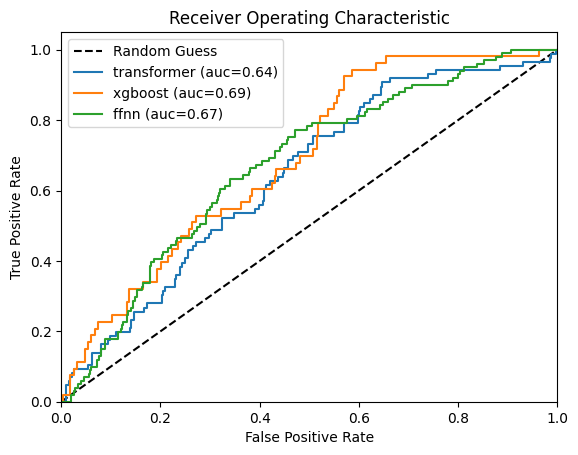

In [76]:
#| label: fig-roc
#| fig-cap: "Receiver operating characteristic"
#| fig-subcap: 
#|   - "Comparison of model ROC"
#| fig-alt:
#|   - "ROC plot of models"
#| layout-ncol: 1

plt.figure()
plt.plot([0,1],[0,1], "k--", label='Random Guess')

for m, df in dfs.items():
    fpr, tpr, _ = metrics.roc_curve(df[meta[m]['y_true']], df[meta[m]['y_pred_proba']])
    auc = metrics.roc_auc_score(df[meta[m]['y_true']], df[meta[m]['y_pred_proba']])
    plt.plot(fpr, tpr, label=f"{m} (auc={auc:.02f})")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
plt.legend(loc="best")
plt.savefig('imgs/fig-roc.png')
plt.show()

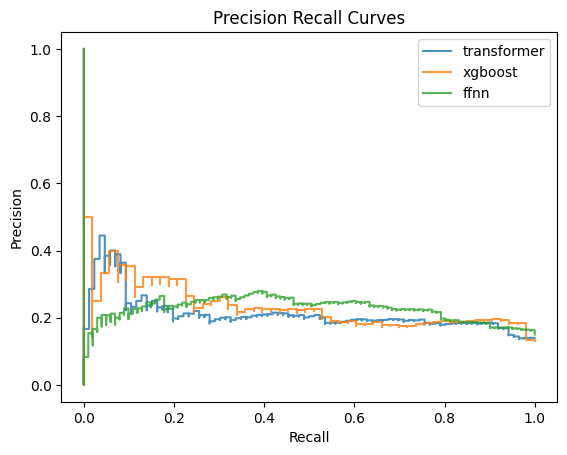

In [77]:
#| label: fig-prc
#| fig-cap: "Precision recall curve"
#| fig-subcap: 
#|   - "Comparison of model precision recall curves"
#| fig-alt:
#|   - "PRC plot of models"
#| layout-ncol: 1

ax = plt.gca()
for m, df in dfs.items():
    precision, recall, threshold = metrics.precision_recall_curve(df[meta[m]['y_true']], 
                                                                  df[meta[m]['y_pred_proba']])
    prd = metrics.PrecisionRecallDisplay(precision, recall)
    prd.plot(ax=ax, alpha=0.8, label=m)
plt.legend(loc="best")
plt.title('Precision Recall Curves')
plt.savefig('imgs/fig-prc.png')
plt.show()

In [78]:
for m, df in _dfs.items():
    print(df.shape)
    print(df.columns.values)

(615, 5)
['y_pred' 'y_pred_proba' 'y_true' 'model' 'iso3']
(406, 5)
['y_pred' 'y_pred_proba' 'y_true' 'model' 'iso3']
(673, 5)
['y_pred' 'y_pred_proba' 'y_true' 'model' 'iso3']


In [79]:
import matplotlib
# https://stackoverflow.com/a/63923910
c_low = matplotlib.colors.colorConverter.to_rgba('lightgreen', alpha = .5)
c_high = matplotlib.colors.colorConverter.to_rgba('green', alpha = 1)
cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('rb_cmap', [c_low, c_high], 512)

/opt/homebrew/Caskroom/miniforge/base/envs/magasin/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 4 classes. Setting k to 3.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/magasin/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 4 classes. Setting k to 3.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/magasin/lib/python3.10/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 4 classes. Setting k to 2.
  warnings.warn(


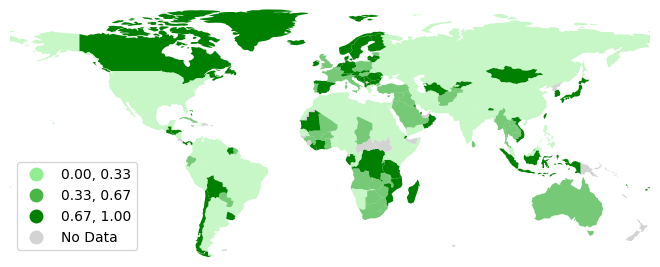

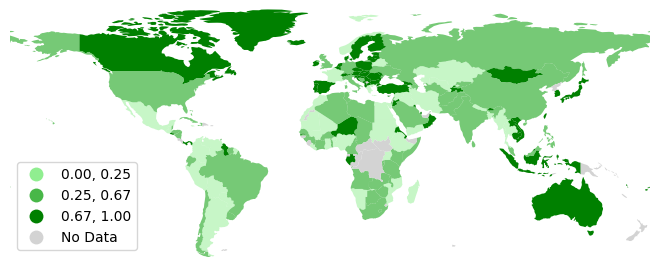

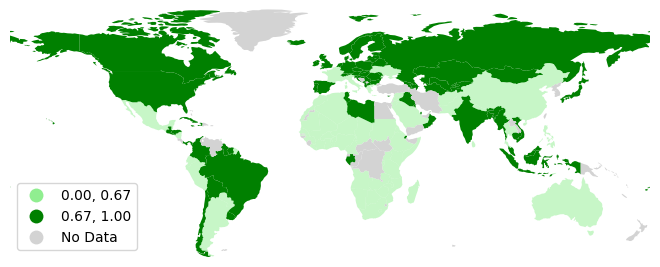

In [80]:
for m, df in _dfs.items():
    _df = df.reset_index()
    col = 'y_pred_proba'
    _df = _df[_df['yearmonth'].isin(common_yearmonths)]
    # World Equidistant Cylindrical projection
    _world = world[(world.pop_est>0) & (world.name!="Antarctica")].to_crs(epsg=4087)
    
    grouped = _df.groupby('iso3').apply(lambda g: metrics.accuracy_score(g['y_true'], g['y_pred']))
    grouped = pd.DataFrame(grouped.reset_index().rename(columns={0: 'accuracy'}), columns=('iso3', 'accuracy'))
    grouped =  _world.merge(grouped, left_on='iso_a3', right_on='iso3', how='outer')
    
    fig =  plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    
    #ax.set_title(f"{mdisplay[m]} model accuracy on test data")
    grouped.plot(column='accuracy', ax=ax, scheme='QUANTILES',
                 missing_kwds={'color': 'lightgrey', 'label': 'No Data'}, k=4, 
                 legend=True, legend_kwds={'loc': 'lower left'},
                 cmap=cmap_rb,)
    # https://stackoverflow.com/a/55162475
    ax.margins(0)
    ax.apply_aspect()
    bbox = ax.get_window_extent()._bbox
    w,h = fig.get_size_inches()
    fig.set_size_inches(w*bbox.width, h*bbox.height)
    plt.gcf().set_size_inches(w*bbox.width, h*bbox.height)
    ax.set_axis_off();
    
    plt.savefig(f'imgs/fig-{m}-test-accuracy.png', bbox_inches="tight", pad_inches=0, dpi=100)

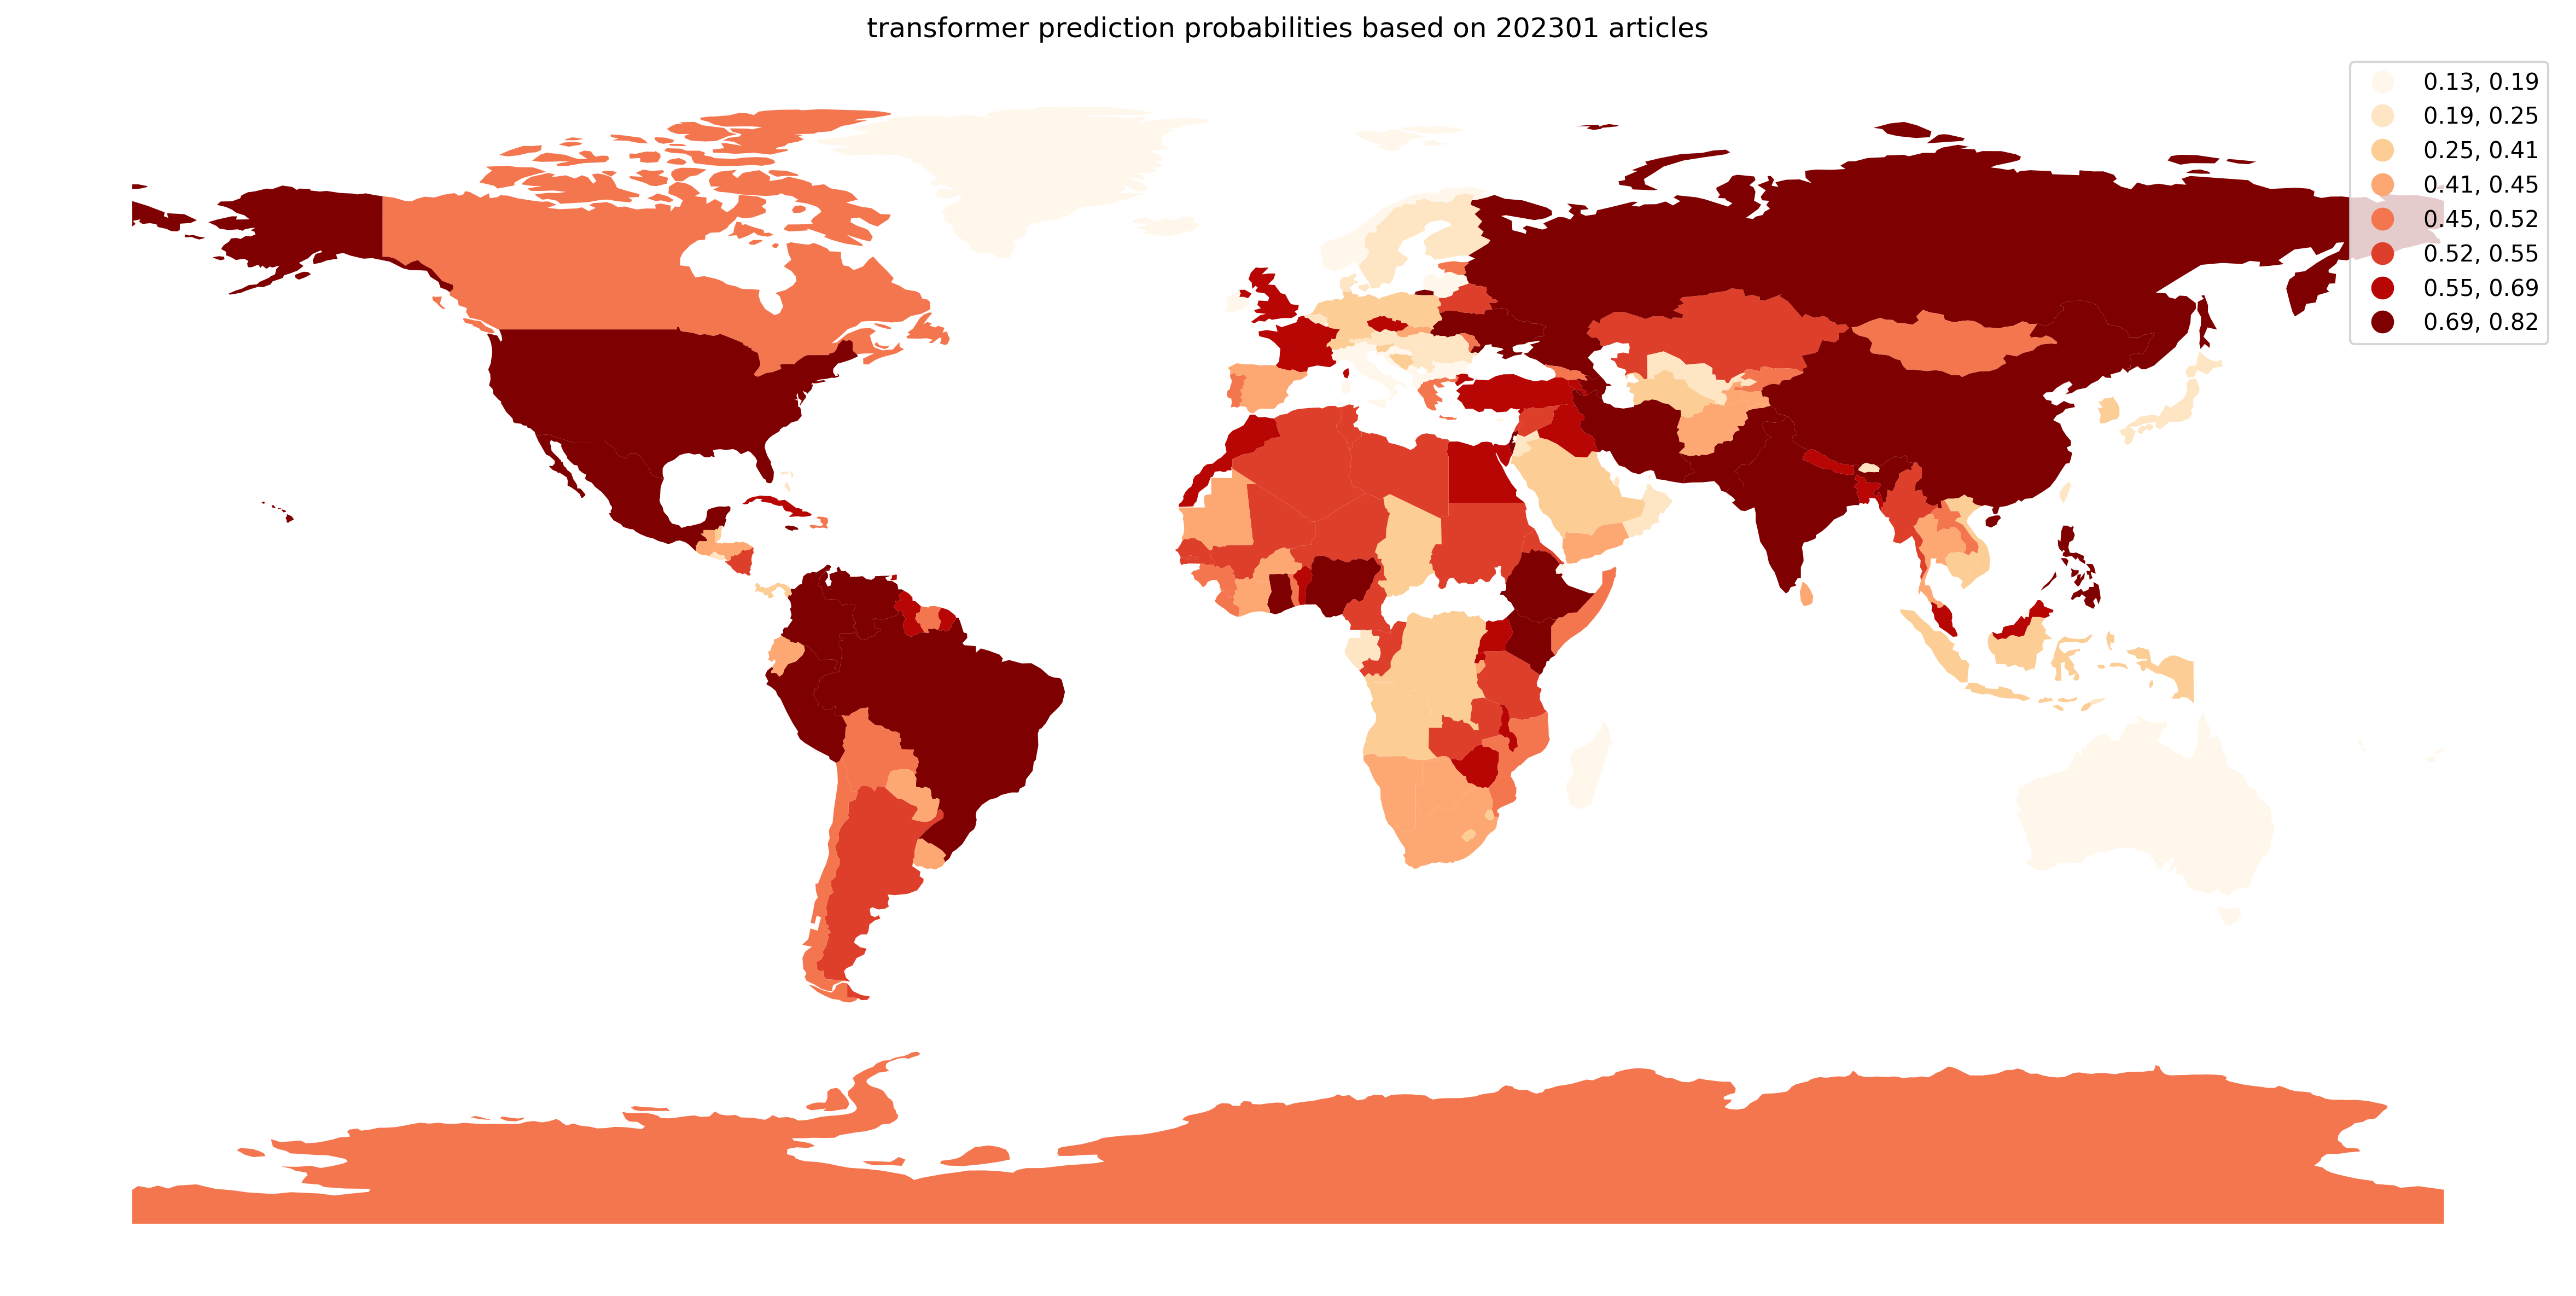

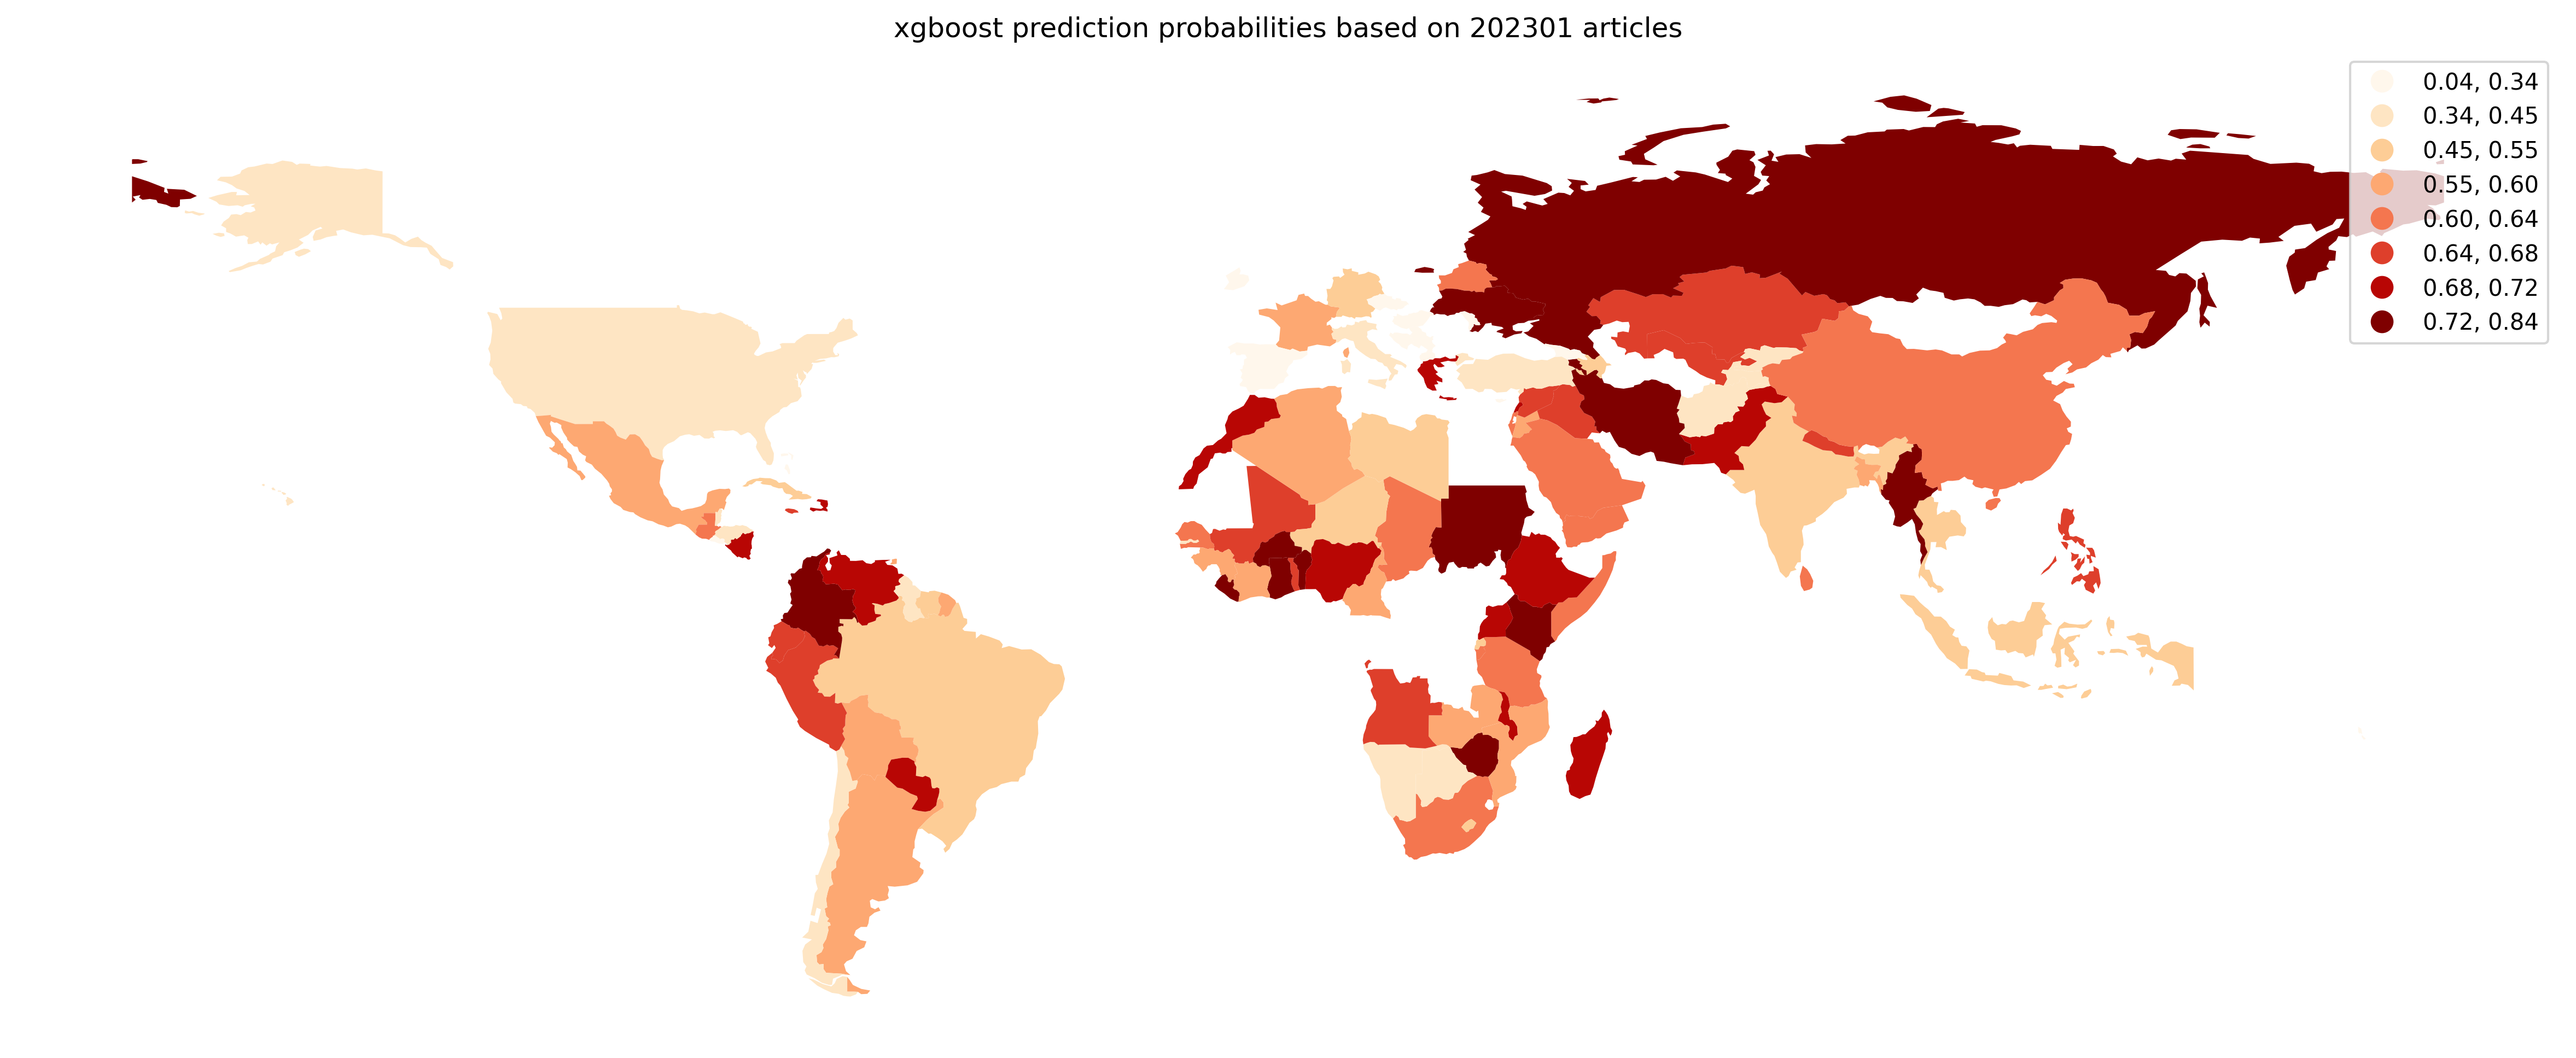

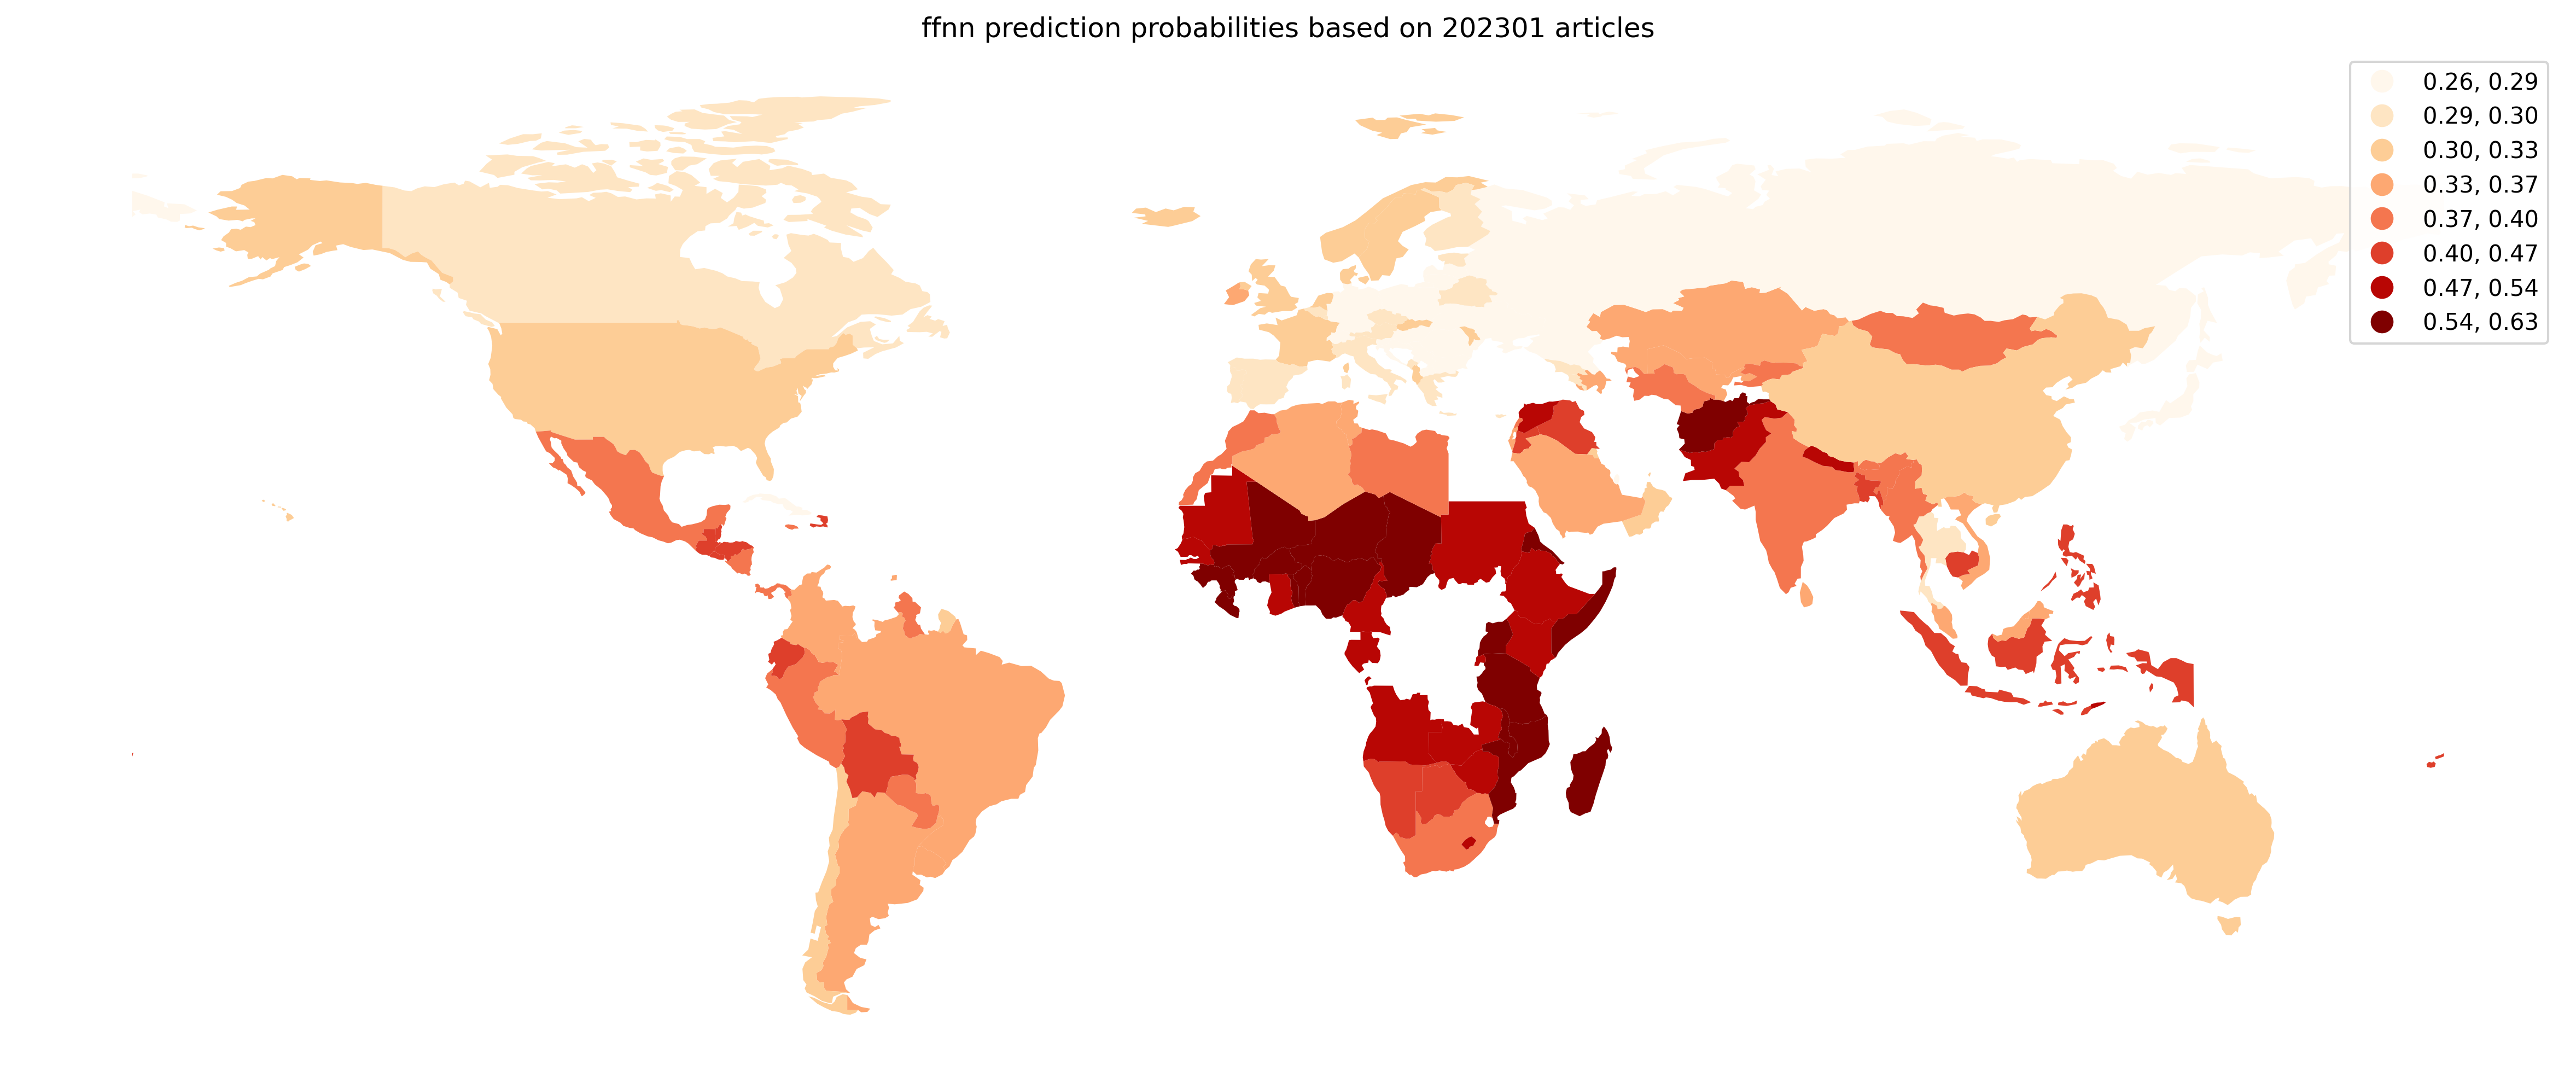

In [94]:
for m, df in _dfs.items():
    _df = df.reset_index()
    col = 'y_pred_proba'
    ym = '202301'
    _df = _df[_df['yearmonth'].isin([ym])]
    _df = world.merge(_df, right_on='iso3', left_on='iso_a3')

    fig, ax = plt.subplots(1, 1, figsize=(20, 18), dpi=300)
    ax.set_title(f"{m} prediction probabilities based on {ym} articles")
    _df.plot(column=col, ax=ax, scheme='QUANTILES', k=8, legend=True,
             cmap="OrRd")
    ax.set_axis_off();
    plt.savefig(f'imgs/fig-{col}-{m}-{ym}.png')

In [82]:
def tooltip_text(row):
    out = f"{row['iso3']}: &emsp;{row['y_true_t']} {row['y_true_x']} {row['y_true']}<br>"
    for m, pro, pre in [('transformer', 'y_pred_proba_t', 'y_pred_t'),
                        ('xgboost', 'y_pred_proba_x', 'y_pred_x'),
                        ('ffnn', 'y_pred_proba', 'y_pred')]:
        out += f"{m}: <br>&emsp;{row[pro]:.02f} ({row[pre]})<br>"
    return out

In [83]:
dfa = world.merge(_dfa.reset_index(), right_on='iso3', left_on='iso_a3')

In [84]:
dfa['tooltip'] = dfa.apply(tooltip_text, axis=1)

In [85]:
ym = '202301'
col = 'y_pred_proba'
_dfa = dfa[dfa['yearmonth'].isin([ym])]
#_dfa = _dfa.dropna()

In [86]:
print(dfa.shape)
print(dfa[dfa['yearmonth'].isin([ym])].shape)

(364, 24)
(90, 24)


In [87]:
_dfa.geometry[(_dfa.geometry.is_empty | _dfa.geometry.isna())]

GeoSeries([], Name: geometry, dtype: geometry)

In [88]:
_dfa.explore(
     column=col, # make choropleth based on this column
     tooltip="tooltip", # show "tooltip" value in tooltip (on hover)
     popup=True, # show all values in popup (on click)
     tiles="CartoDB positron", # use "CartoDB positron" tiles
     cmap='OrRd',
     style_kwds=dict(color="darkgrey") # use darkgrey outline
)

In [89]:
df_reduced_2d = pd.read_feather('umap_reduced_2d.feather')

In [90]:
%%time
if not pathlib.Path('imgs/fig-umap2d-jointplot.png').exists():
    sns.jointplot(x=df_reduced_2d['one'], y=df_reduced_2d['two'], kind="kde")
    plt.savefig('imgs/fig-umap2d-jointplot.png')
    plt.show()

CPU times: user 159 µs, sys: 89 µs, total: 248 µs
Wall time: 217 µs


In [91]:
if not pathlib.Path('imgs/fig-umap2d-ds-targets.png').exists():
    cvs = ds.Canvas(plot_width=850, plot_height=500)
    agg = cvs.points(df_reduced_2d, 'one', 'two', agg=ds.by('label', ds.count()))
    img = ds.tf.shade(agg, cmap=colorcet.fire, how='log')
    export_image(img, "fig-umap2d-ds-targets", background="black", export_path="imgs/")
    img